In [1]:
import numpy as np 
import pylab as pl 
import glob
import os
from os.path import isfile,join
from os import listdir
import csv
import gpflow
import seaborn as sns
from astropy.stats import median_absolute_deviation, sigma_clip
import gc

%matplotlib inline 

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".92"})
sns.set_palette(sns.color_palette("husl"))

In [3]:
root = "../data/"
all_files = glob.glob(os.path.join(root, "AGN/GBI/*"),recursive=True) 
allfiles = []
for path, subdirs, files in os.walk(root):
    subdirs[:] = [d for d in subdirs if d not in ['GBI']]
    for filename in files:
        f = os.path.join(path, filename)
        allfiles.append(f)
    

In [ ]:
allfiles

In [ ]:
for file in all_files:
    if isfile(file):
        data = np.loadtxt(file,usecols=[0,1,2])
        pl.plot(data[:,0],data[:,1])

In [4]:
def get_sigma_clipped_fluxes(raw_fluxes):
    """
    Uses the astropy sigma_clip function to try and get rid of outliers.

    ( https://astropy.readthedocs.org/en/stable/api/astropy.stats.sigma_clip.html )

    Returns a masked array where all outlier values are masked.
    """

    # First we try to run sigma clip with the defaults - hopefully this will
    # iterate until it converges:
    clipped_fluxes = sigma_clip(raw_fluxes, iters=None,
                                stdfunc=median_absolute_deviation)
    # If it fails (number of unmasked values <3),
    # then we just accept the result from a single iteration:
    if len(clipped_fluxes.compressed()) < 3:
        logger.warning("Sigma clipping did not converge, "
                       "using single iteration")
        clipped_fluxes = sigma_clip(raw_fluxes, iters=1,
                                    stdfunc=median_absolute_deviation)
    return clipped_fluxes


def get_ls(x,y,err):
    clipped_fluxes = get_sigma_clipped_fluxes(y)
    background = np.ma.median(clipped_fluxes)
    noise = median_absolute_deviation(clipped_fluxes)

    rise_threshold = background + 5 * noise
    fall_threshold = background + 1 * noise 
    flux_plus_err = y + err
    
    trigger = np.where(flux_plus_err > rise_threshold)[0]
    if len(trigger) == 0: 
        trigger = np.where(flux_plus_err == np.max(flux_plus_err))[0][0]
    else: 
        trigger = trigger[0]

    indexes = np.where(y < fall_threshold)[0]
    if len(indexes) == 0: 
        indexes = np.where(y < background)[0]
    
    fall_indexes = np.array([indexes[i] for i in range(len(indexes)-1) if y[indexes[i]] > y[indexes[i+1]]])

    fall = np.where(fall_indexes > trigger)[0]
    if len(fall) == 0:
        fall_idx = len(y) - 1
    else:
        fall_idx = fall_indexes[np.where(fall_indexes > trigger)][0]
        
    rise = np.where(indexes <= trigger)[0]
    if len(rise) == 0:
        rise_idx = trigger
    else: 
        rise_idx = indexes[np.where(indexes < trigger)][-1]
        
    return  ((x[fall_idx] - x[rise_idx]))/(2*np.sqrt(2*np.log(2)))
    
def loadfile(file):
    if "GBI" in file:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,3],data[:,6]
        y_eq_minus1 = np.where(y == -1)
        y = np.delete(y,y_eq_minus1)
        x = np.delete(x,y_eq_minus1)
        err =  np.delete(err,y_eq_minus1)

    else:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,1],data[:,2]
    
    return x,y,err


def sample_curve(x,y,err,xsample_range,num_of_sample_curves,filename):
    
    clipped_fluxes = get_sigma_clipped_fluxes(y)
    background = np.ma.median(clipped_fluxes)
    noise = median_absolute_deviation(clipped_fluxes)
    
    ls = get_ls(x,y,err)
    var = noise
    
    print('Background = ',background)
    print('Noise = ', noise)
    print('ls = ',ls)
    
    k = gpflow.kernels.RBF(1,lengthscales=ls,variance=var)
    m = gpflow.gpr.GPR(x.reshape(len(x),1), y.reshape(len(y),1), kern=k)
    m.kern.lengthscales.prior = gpflow.priors.Gaussian(ls, ls/5)
    m.kern.variance.prior = gpflow.priors.Gaussian(5*var, var)
    m.optimize()

    xx = np.linspace(min(x), max(x), 1000)[:,None]
    mean, var = m.predict_y(xx)

    pl.figure(figsize=(12, 6))
    pl.plot(x, y, 'kx', mew=2)
    pl.plot(xx, mean, 'b', lw=2)
    pl.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    pl.xlabel('Days [JD]')
    pl.ylabel('Flux  [Jy]')
    pl.savefig(filename+'.png')
    pl.close()
    
    xnew = xsample_range
    ynew = m.predict_f_samples(xsample_range[:,None],num_of_sample_curves)
    return xnew,ynew



def sample_curve_plots(x,y,err,xsample_range,num_of_sample_curves):
    pl.figure(figsize=(12,6))
    pl.title('Data')
    pl.errorbar(x,y,err)
    pl.show()
    ls = get_ls(x,y)
    k = gpflow.kernels.RBF(1,lengthscales=ls,variance=y.max() - y.min())
    m = gpflow.gpr.GPR(x.reshape(len(x),1), y.reshape(len(y),1), kern=k)
    
    m.optimize()
    
    xx = np.linspace(min(x), max(x), 1000)[:,None]
    mean, var = m.predict_y(xx)

    pl.figure(figsize=(12, 6))
    pl.plot(x, y, 'kx', mew=2)
    pl.plot(xx, mean, 'b', lw=2)
    pl.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    
    xnew = xsample_range[:,None]
    ynew = m.predict_f_samples(xnew,num_of_sample_curves)

    for i in range(num_of_sample_curves):
        pl.plot(xnew,ynew[i],'x')

    pl.show()
    return xnew,ynew





In [5]:
def test(file,ls = None,var = None):
    if "GBI" in file:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,3],data[:,6]
        y_eq_minus1 = np.where(y == -1)
        y = np.delete(y,y_eq_minus1)
        x = np.delete(x,y_eq_minus1)
        err =  np.delete(err,y_eq_minus1)
    else:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,1],data[:,2]

    
    pl.figure(figsize=(12, 6))
    pl.plot(x, y, 'kx', mew=2)
    pl.xlabel('Days [JD]')
    pl.ylabel('Flux  [Jy]')
    pl.show()
    
    clipped_fluxes = get_sigma_clipped_fluxes(y)
    background = np.ma.median(clipped_fluxes)
    noise = median_absolute_deviation(clipped_fluxes)
    print('Background = ',background)
    print('Noise = ', noise)
    
    if ls == None:
        ls = get_ls(x,y,err)
    if var == None:
        var = noise
        
    print('ls = ',ls)
    k = gpflow.kernels.RBF(1,lengthscales=ls,variance=var)
    m = gpflow.gpr.GPR(x.reshape(len(x),1), y.reshape(len(y),1), kern=k)
    m.kern.lengthscales.prior = gpflow.priors.Gaussian(ls, ls/5)
    m.kern.variance.prior = gpflow.priors.Gaussian(5*var, var)
    m.optimize()

    xx = np.linspace(min(x), max(x), 1000)[:,None]
    mean, var = m.predict_y(xx)

    pl.figure(figsize=(12, 6))
    pl.plot(x, y, 'kx', mew=2)
    pl.plot(xx, mean, 'b', lw=2)
    pl.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    pl.xlabel('Days [JD]')
    pl.ylabel('Flux  [Jy]')
    pl.show()

# Running GPFlow

1 ../data/TDE/Swift1644.txt


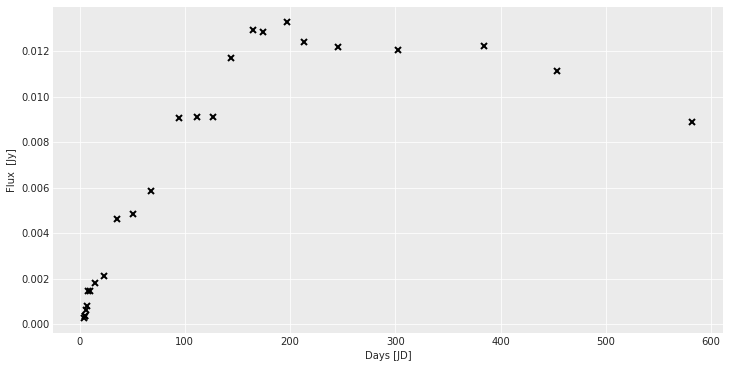

Background =  0.0089
Noise =  0.00403
ls =  16.4980759706


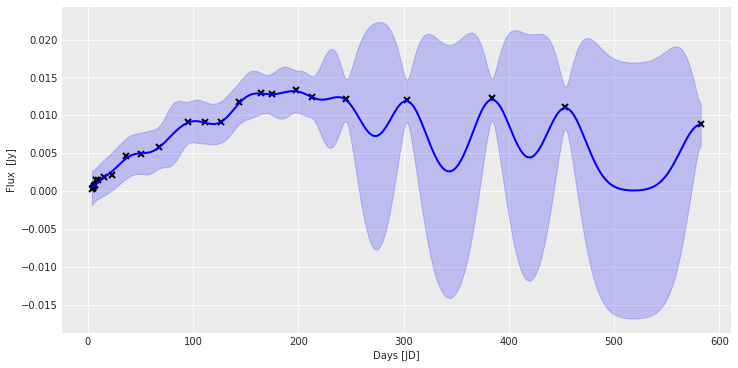

2 ../data/SN/SN1988z.txt


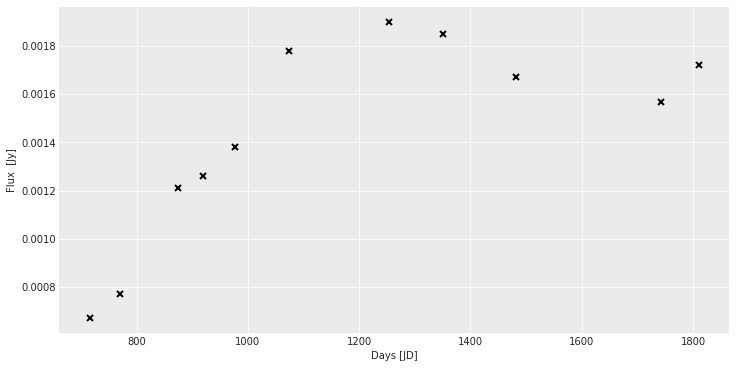

Background =  0.00167
Noise =  0.00018
ls =  173.261647259


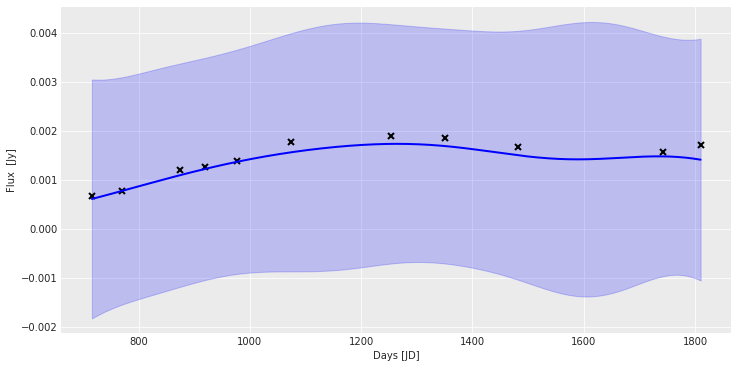

3 ../data/SN/SN1980K.txt


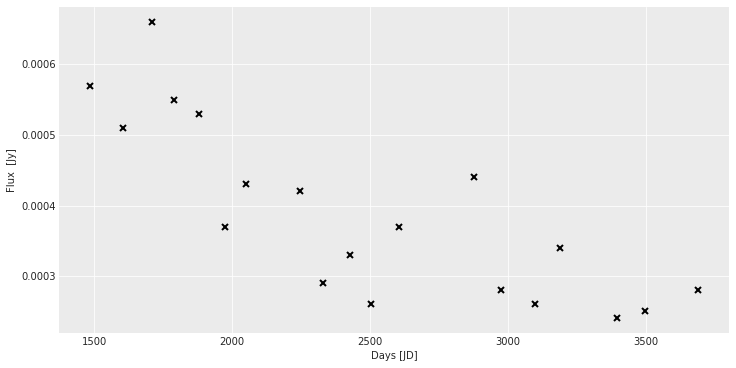

Background =  0.000355
Noise =  8e-05
ls =  144.809366949


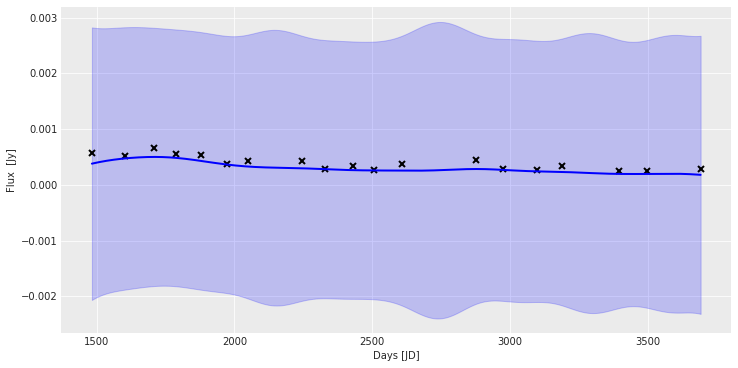

4 ../data/SN/SN2004dk.txt


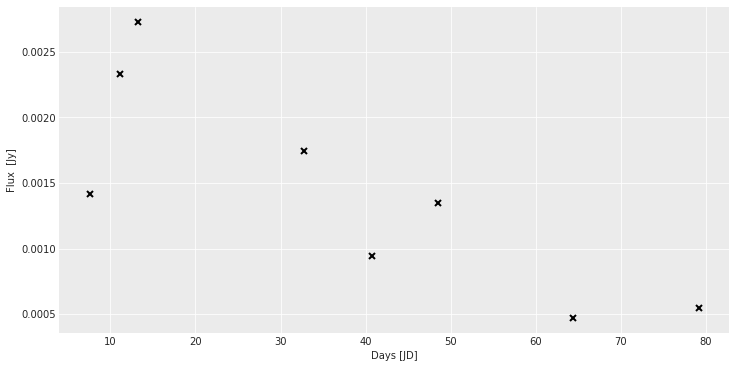

Background =  0.00138348938351
Noise =  0.00063824399754
ls =  10.6897788926


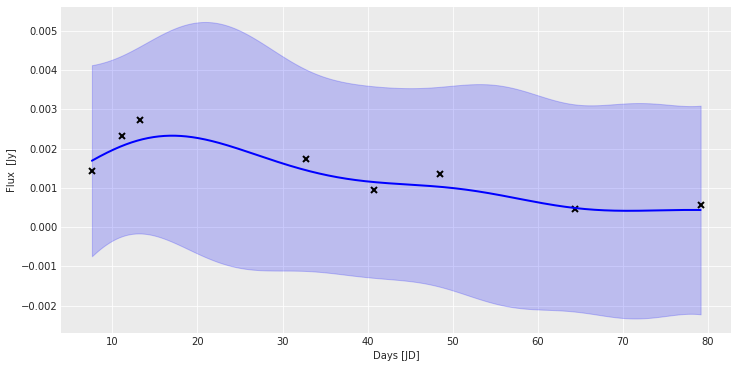

5 ../data/SN/SN1998bw.txt


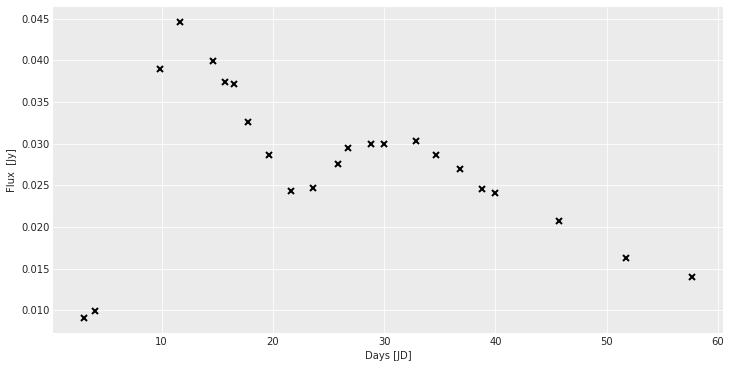

Background =  0.02905
Noise =  0.00395
ls =  5.86032042199


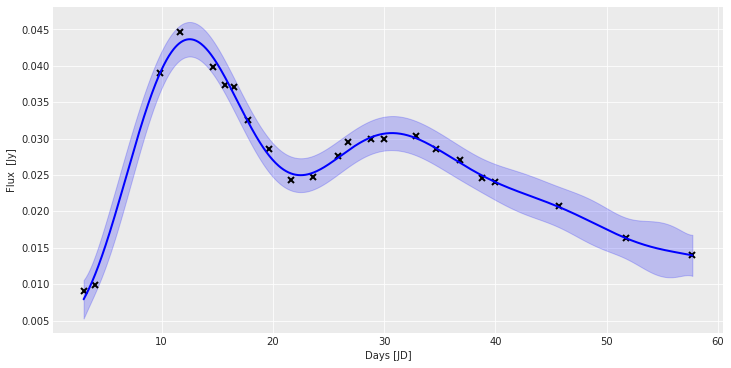

6 ../data/SN/SN1993J.txt


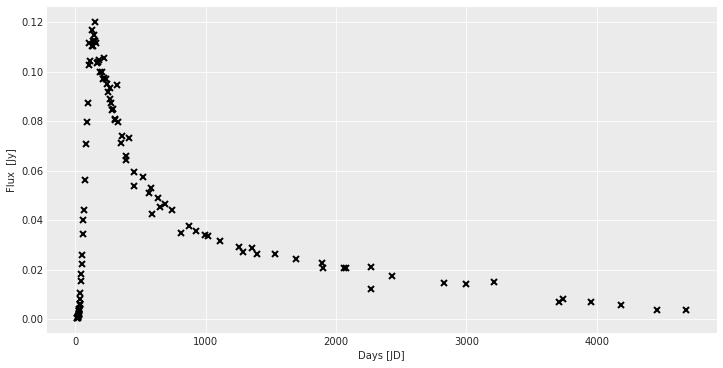

Background =  0.03885
Noise =  0.033177
ls =  114.267755011


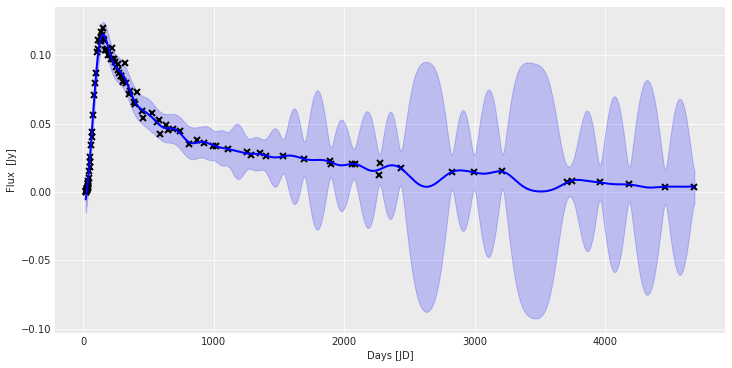

7 ../data/SN/SN2008iz


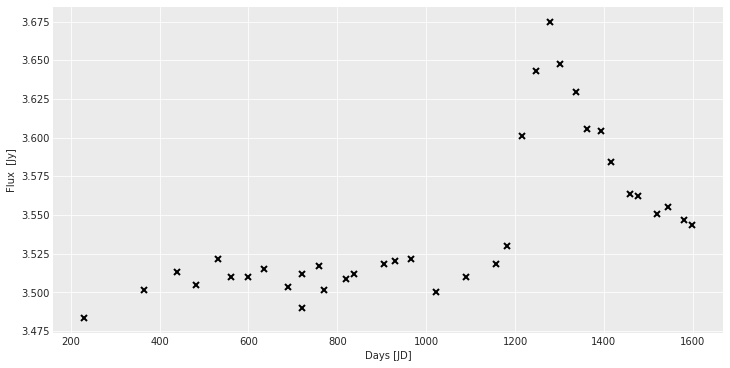

Background =  3.5117647059
Noise =  0.0067226891
ls =  216.658026832


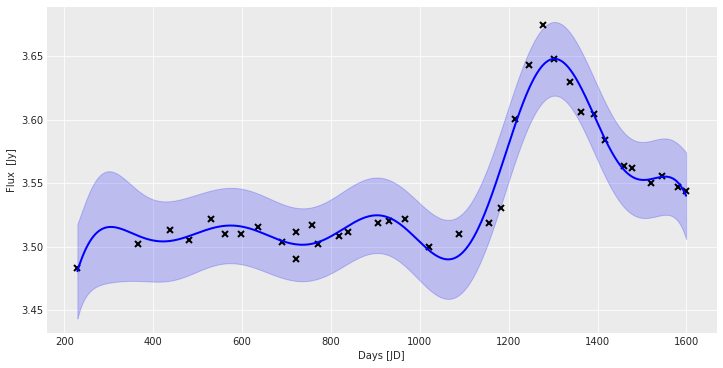

8 ../data/SN/SN2008ax.txt


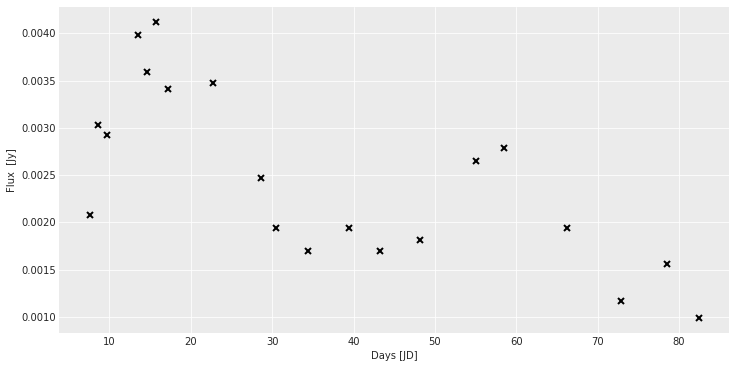

Background =  0.00227579385
Noise =  0.0006159243
ls =  8.91871866159


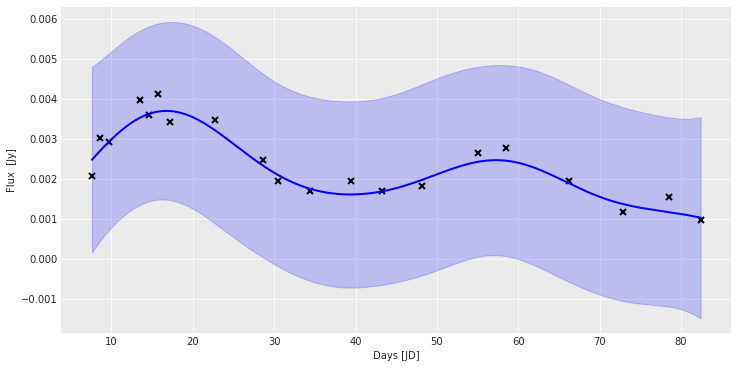

9 ../data/SN/SN2003bg.txt


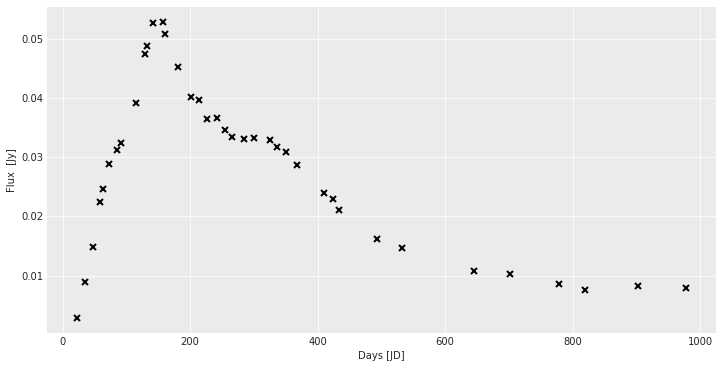

Background =  0.03114
Noise =  0.00877
ls =  42.0414291143


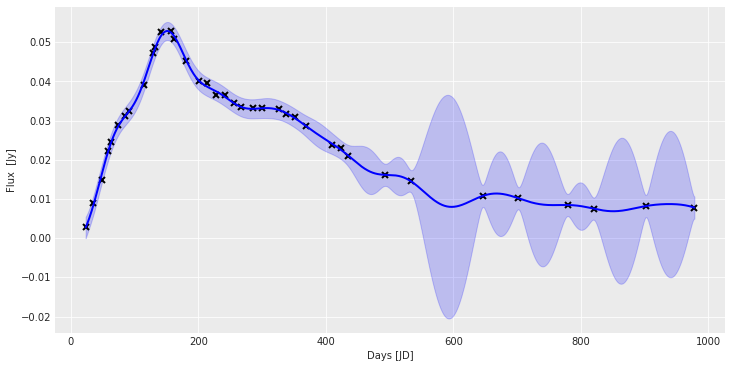

10 ../data/SN/SN2004cc.txt


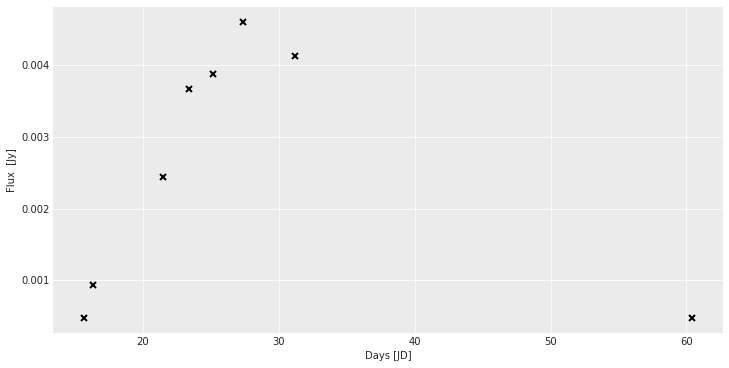

Background =  0.00305
Noise =  0.001315
ls =  2.57008298085


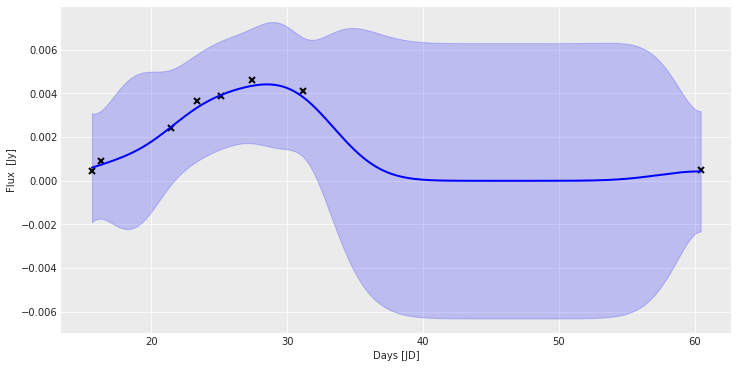

11 ../data/SN/SN1994I.txt


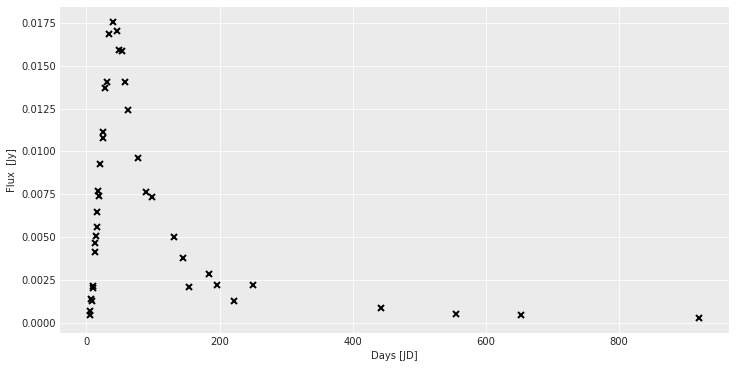

Background =  0.002098
Noise =  0.0014965
ls =  73.5567884966


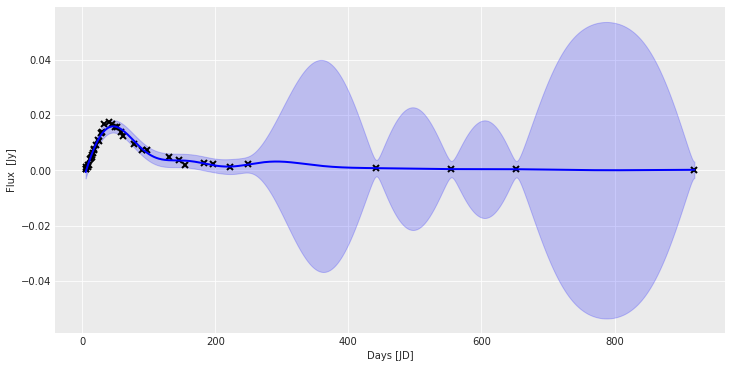

12 ../data/SN/SN2003L.txt


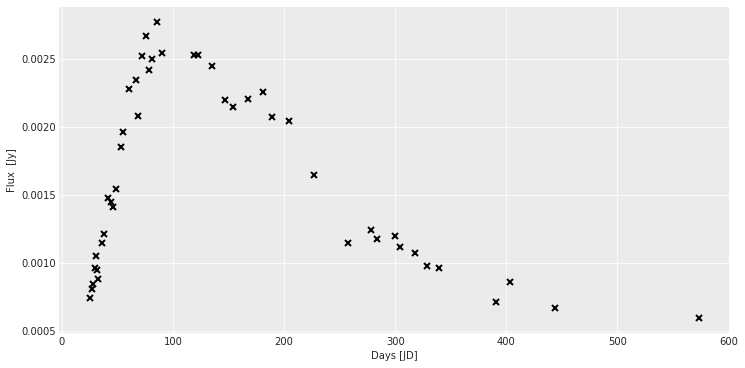

Background =  0.0014655
Noise =  0.000606
ls =  63.1470758514


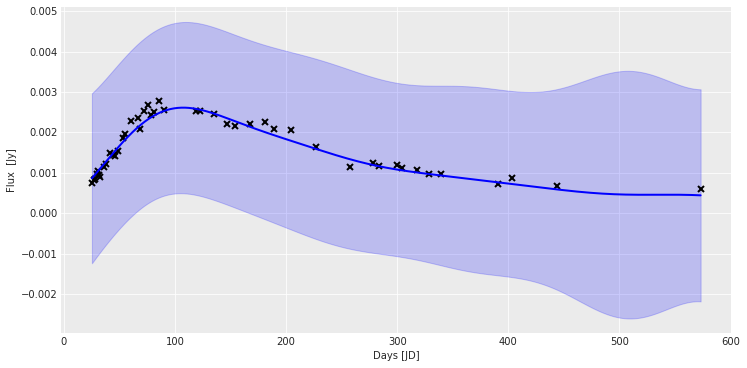

13 ../data/SN/SN2011dh.txt


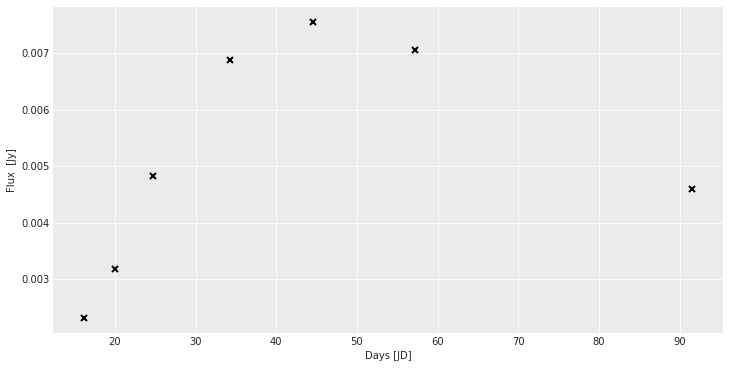

Background =  0.00483504895413
Noise =  0.00204111986862
ls =  28.3637961108


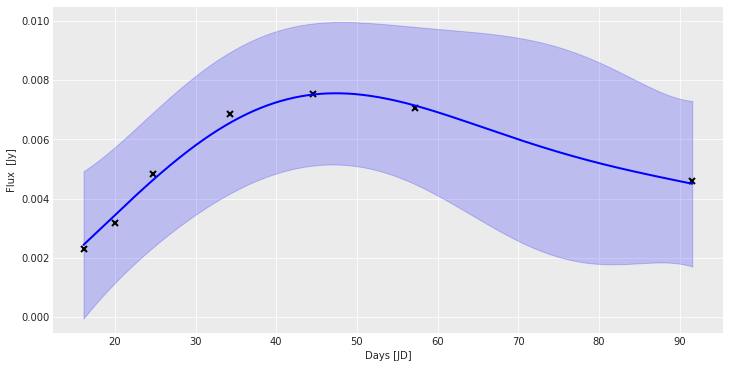

14 ../data/SN/SN2004gq.txt


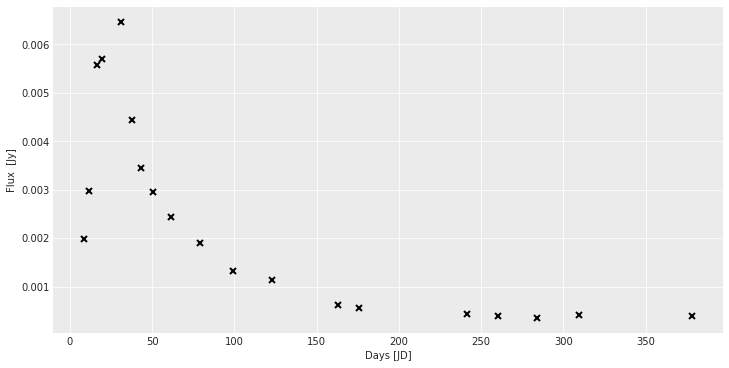

Background =  0.000417715702389
Noise =  9.84142649196e-06
ls =  106.950096735


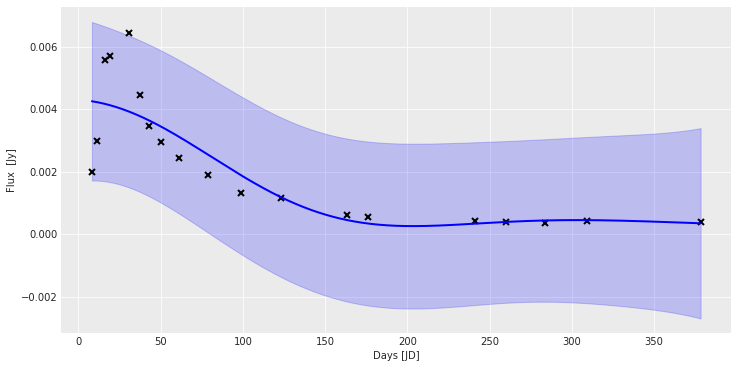

15 ../data/AGN/0528+134p


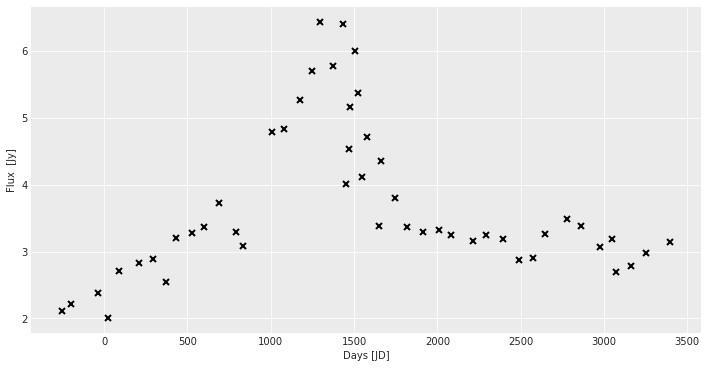

Background =  3.2661595038
Noise =  0.0822457612
ls =  110.280785424


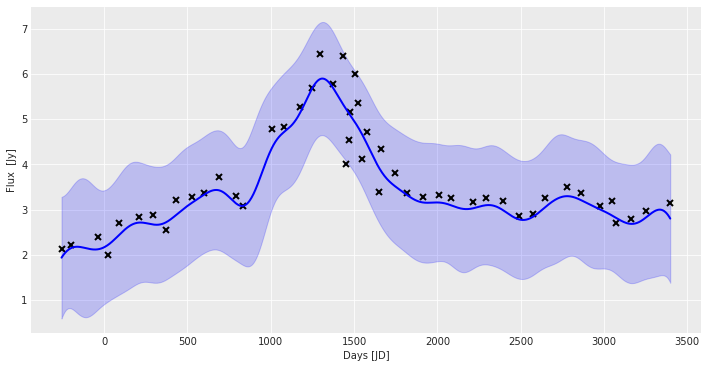

16 ../data/AGN/3C273


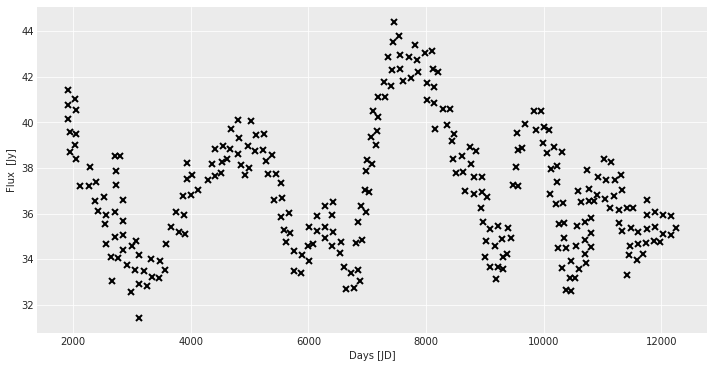

Background =  36.3310378381
Noise =  1.6879868172
ls =  678.46261685


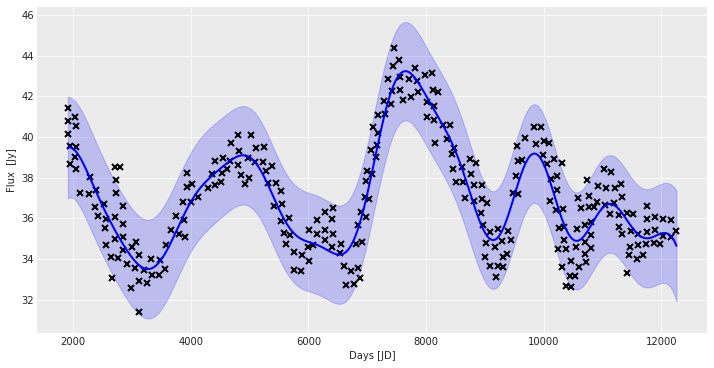

17 ../data/AGN/3C345


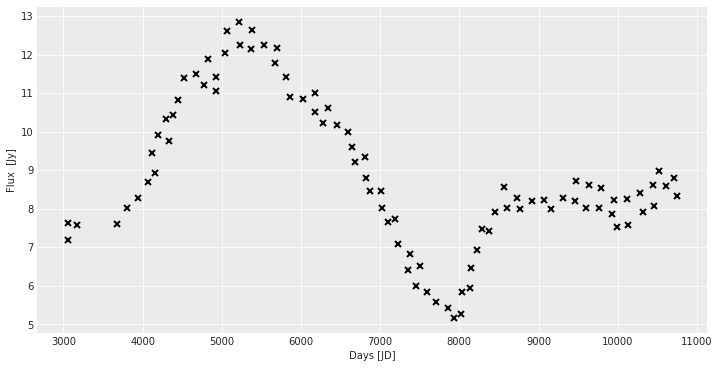

Background =  8.1944256131
Noise =  0.2826295259
ls =  1298.39066084


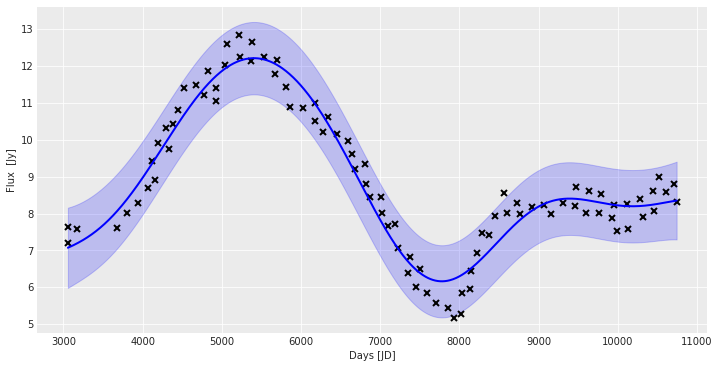

18 ../data/AGN/0458-020


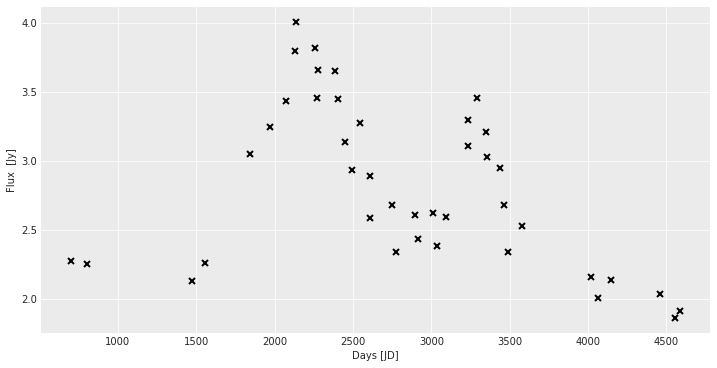

Background =  2.6842574868
Noise =  0.4546389227
ls =  276.301688013


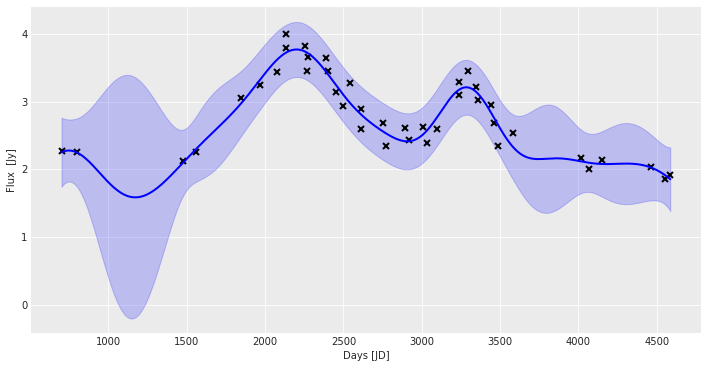

19 ../data/AGN/CTA102


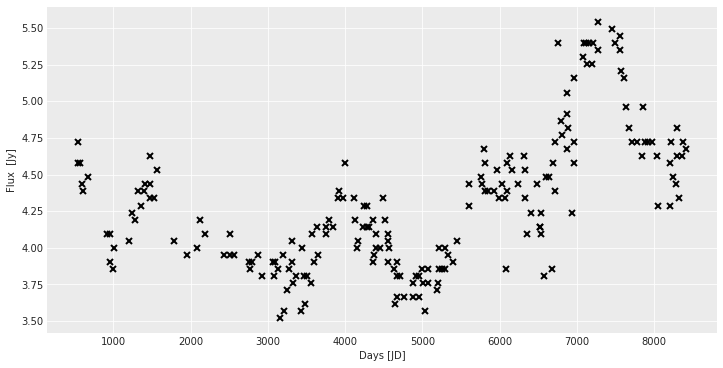

Background =  4.1445783133
Noise =  0.2891566265
ls =  625.302058685


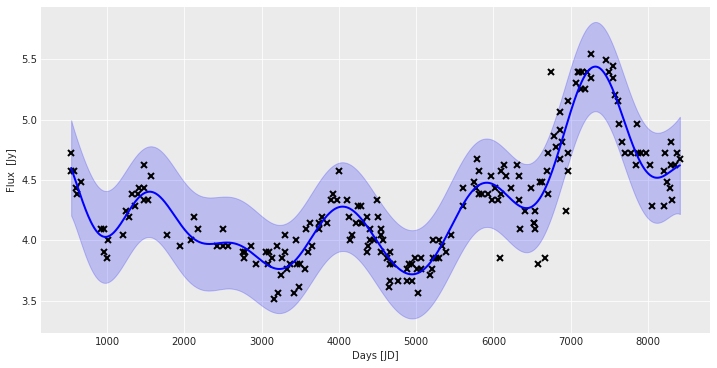

20 ../data/AGN/3C279


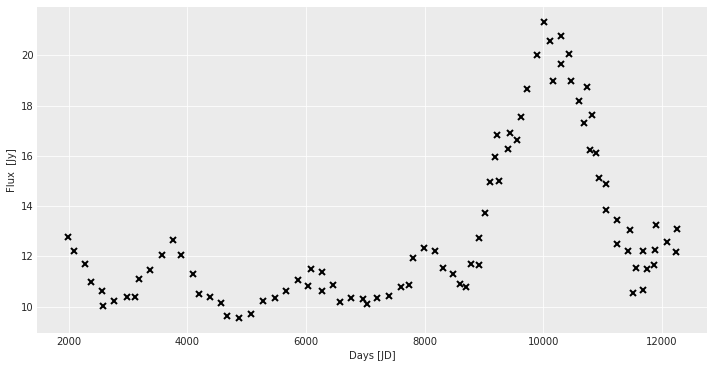

Background =  11.2911280757
Noise =  0.9128744791
ls =  1126.36018266


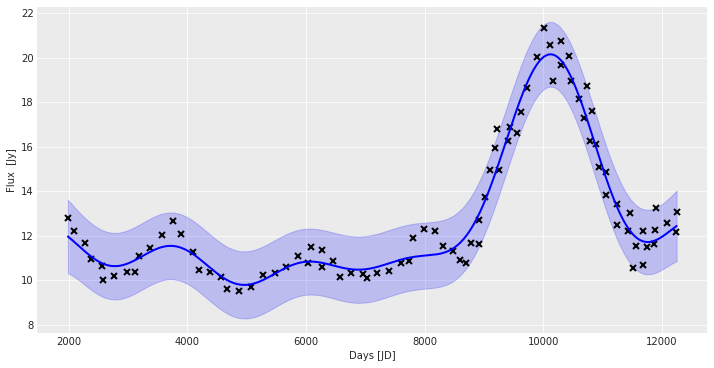

21 ../data/AGN/NGC4278.txt


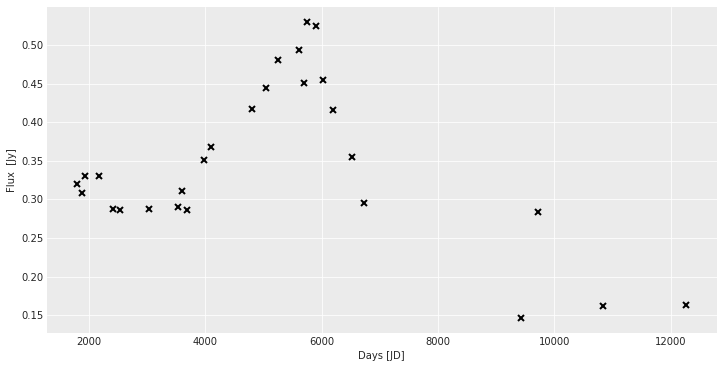

Background =  0.3087719298
Noise =  0.0210526316
ls =  1289.65698197


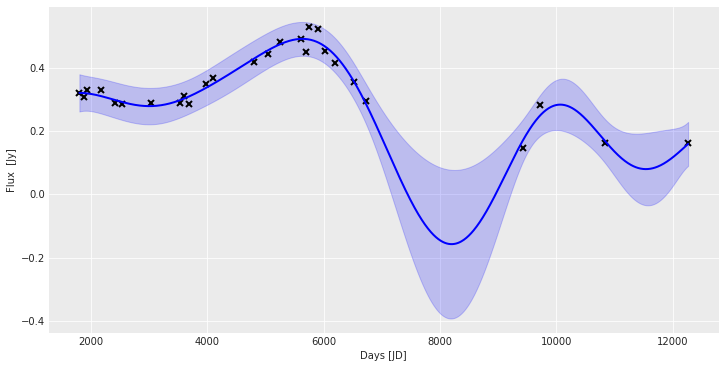

22 ../data/AGN/0954+65


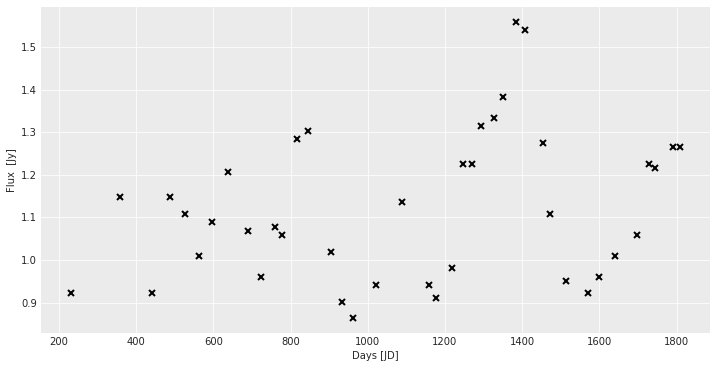

Background =  1.0833333333
Noise =  0.13725490195
ls =  108.328973432


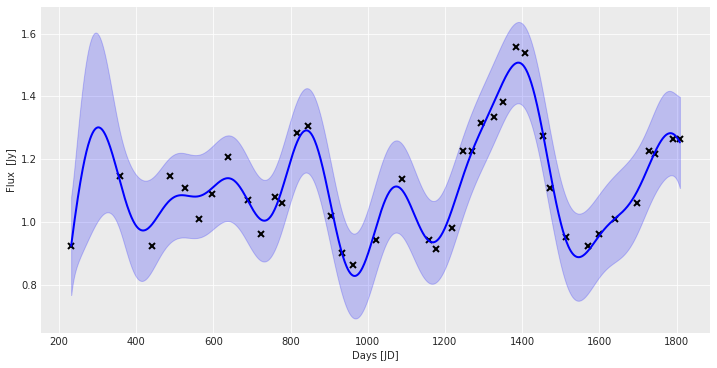

23 ../data/AGN/AO0235+164


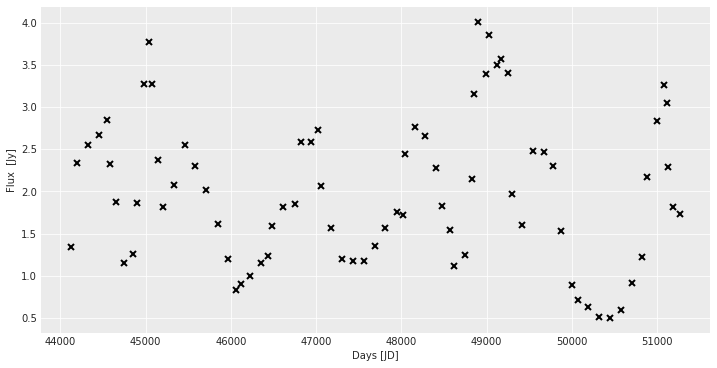

Background =  1.8460909937
Noise =  0.6178275758
ls =  199.433209044


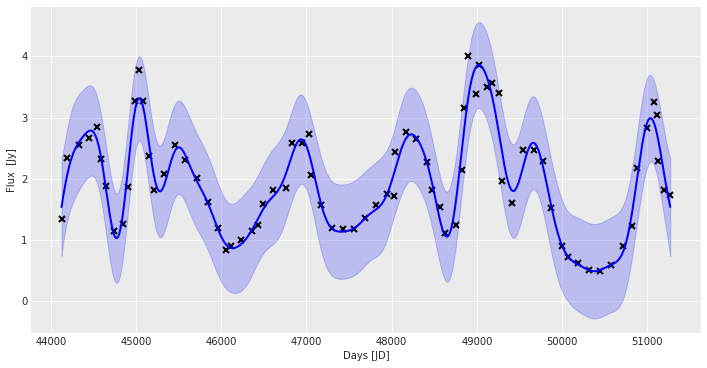

24 ../data/AGN/3C120


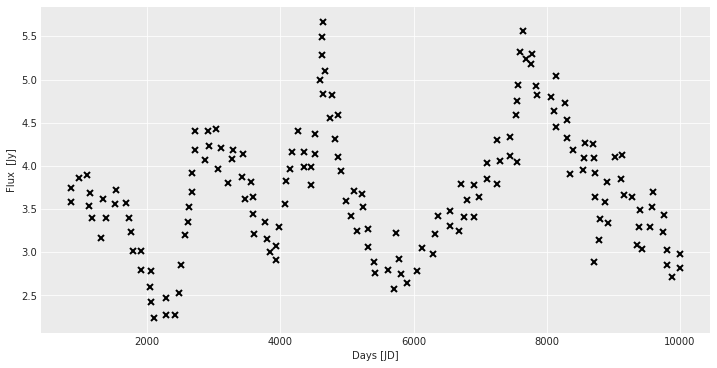

Background =  3.6353326063
Noise =  0.423072822
ls =  186.96263158


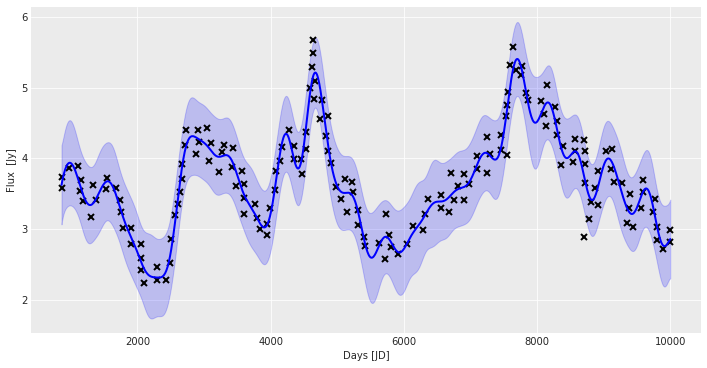

25 ../data/AGN/PKS2004-447.txt


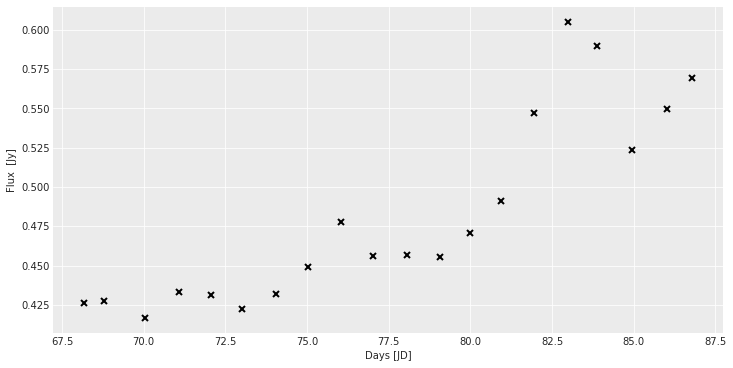

Background =  0.4330222538
Noise =  0.0162838542
ls =  5.41397984895


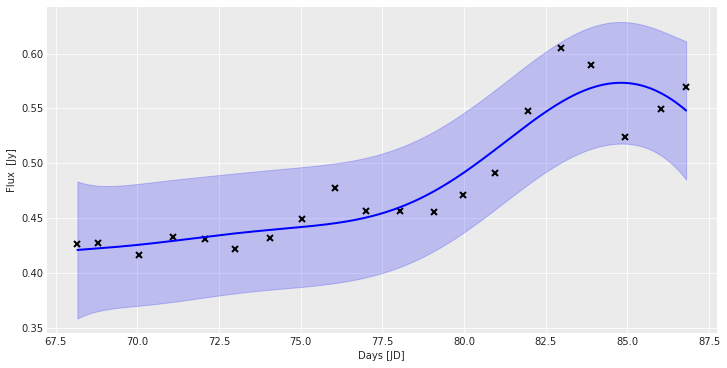

26 ../data/AGN/NRAO530


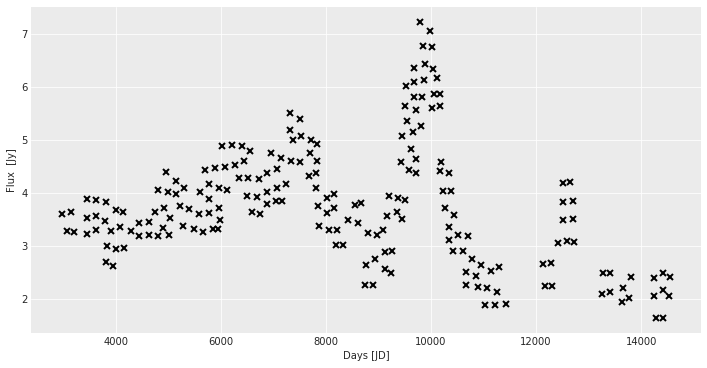

Background =  3.628792772
Noise =  0.42401548855
ls =  286.684966549


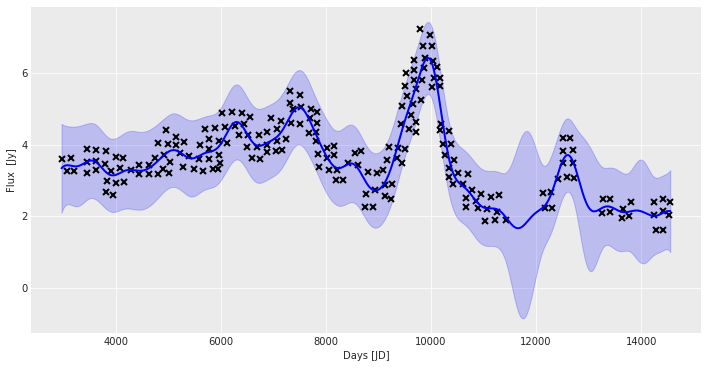

27 ../data/AGN/1803+784


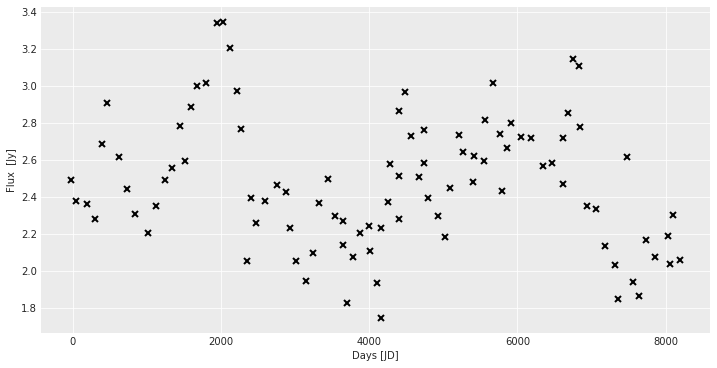

Background =  2.438266686
Noise =  0.229105694
ls =  377.763520478


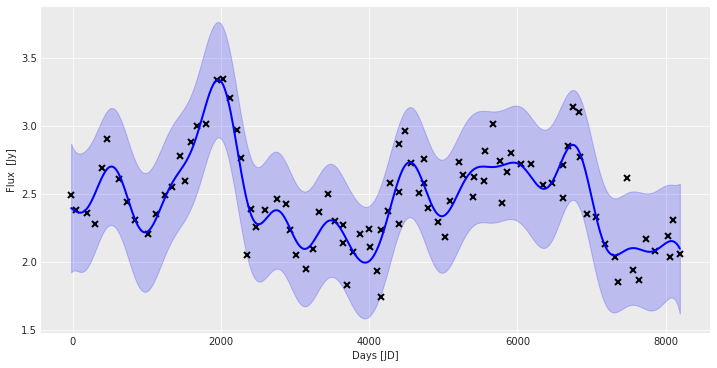

28 ../data/AGN/B0605-085


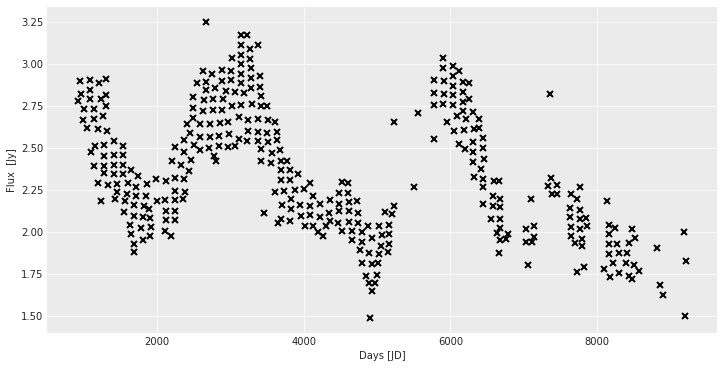

Background =  2.3014246107
Noise =  0.2839438808
ls =  54.9210119406


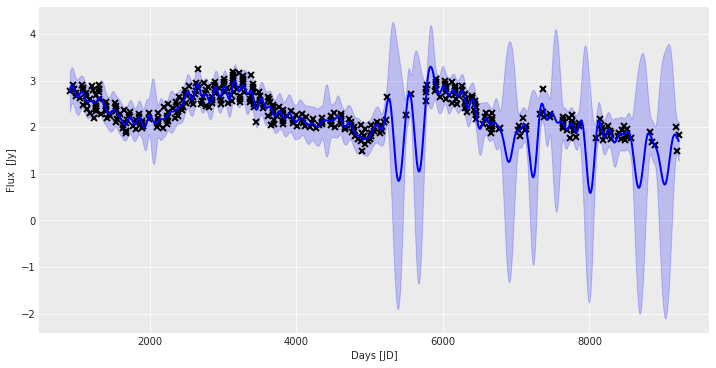

29 ../data/AGN/2223-052


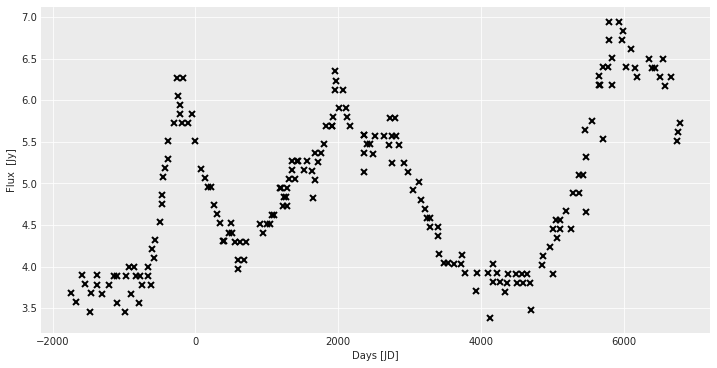

Background =  4.881713555
Noise =  0.7985933504
ls =  456.198216993


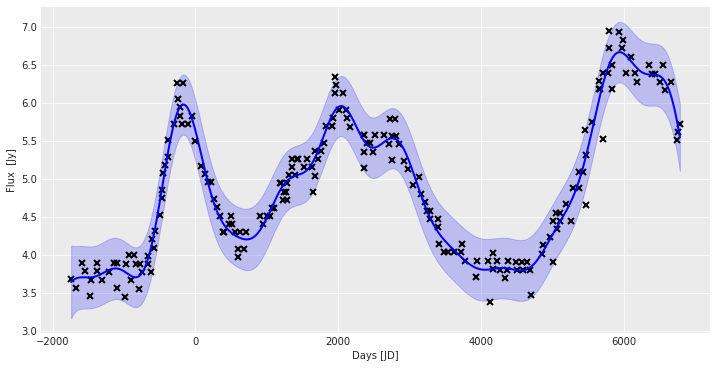

30 ../data/AGN/NGC7213


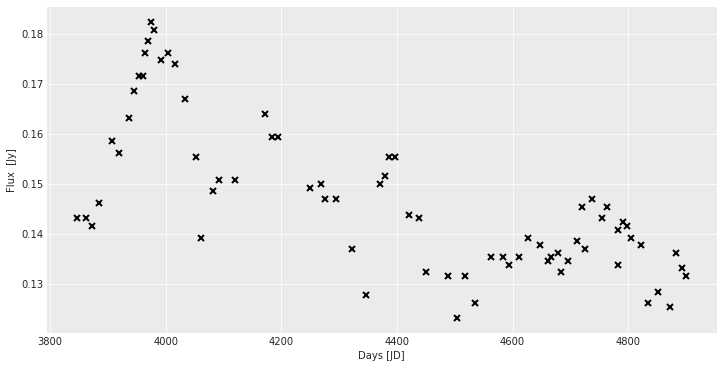

Background =  0.1392307692
Noise =  0.00615384615
ls =  80.0260831273


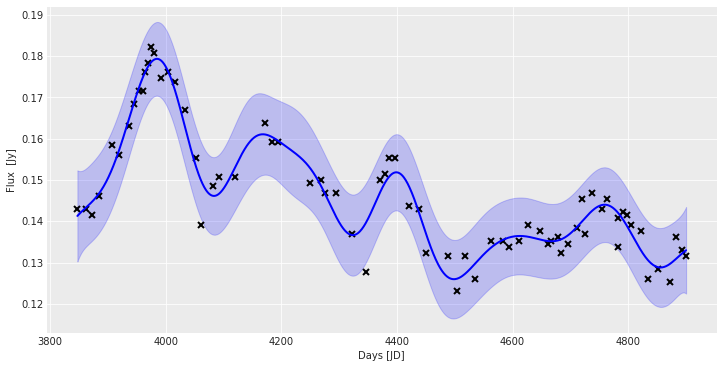

31 ../data/AGN/3C454.3


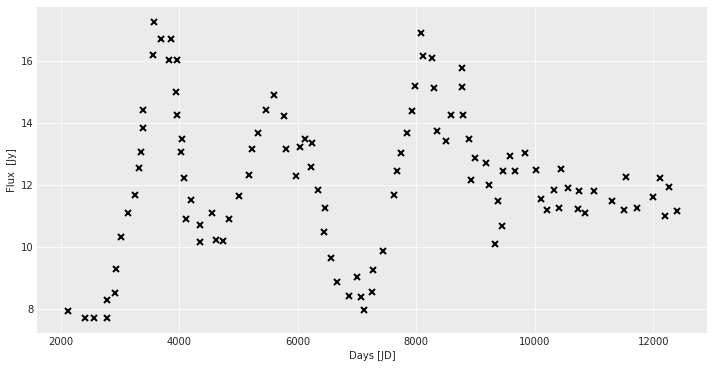

Background =  12.2181001442
Noise =  1.0128788769
ls =  280.967952625


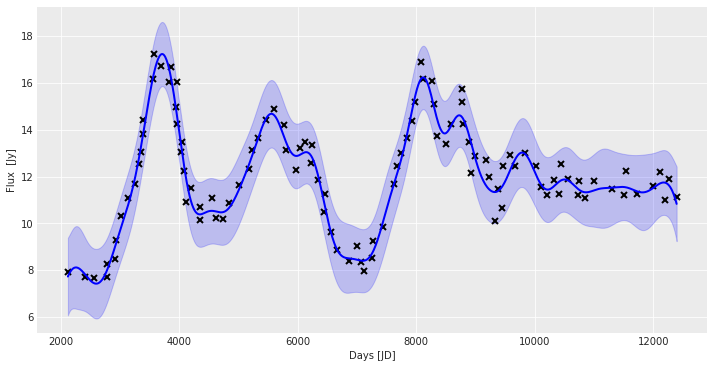

33 ../data/XRB/MAXIJ1836-194


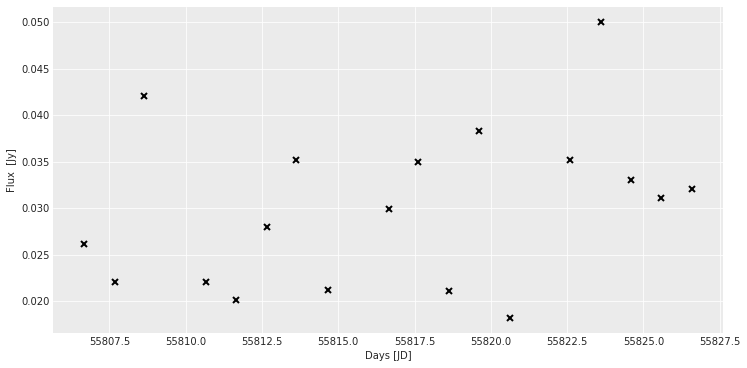

Background =  0.0299183673
Noise =  0.0052244898
ls =  1.69193163499


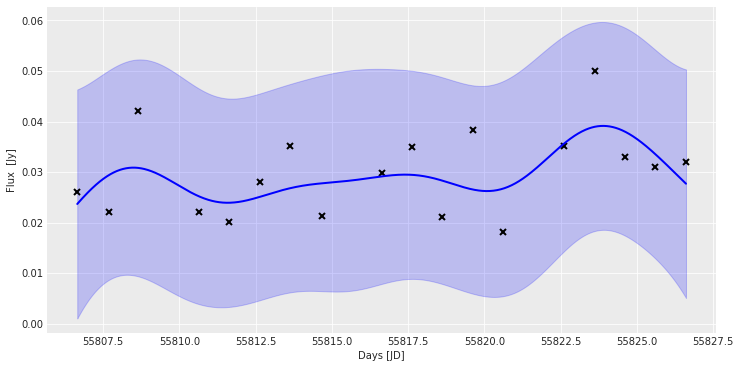

35 ../data/XRB/SS433


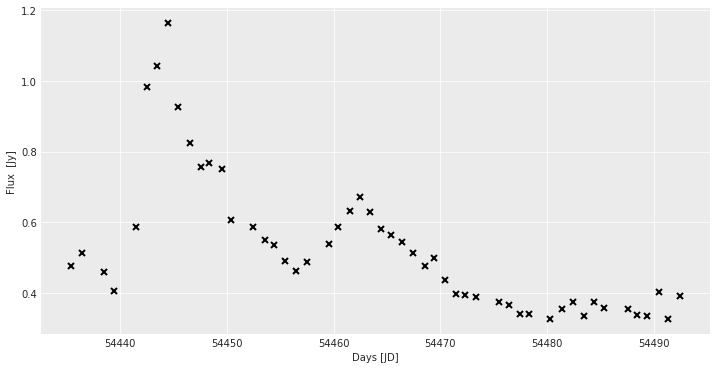

Background =  0.4589492937
Noise =  0.0846690683
ls =  6.37551364992


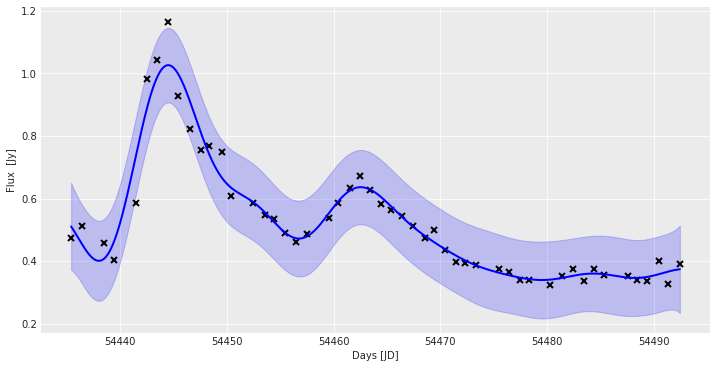

36 ../data/XRB/GX339-4.txt


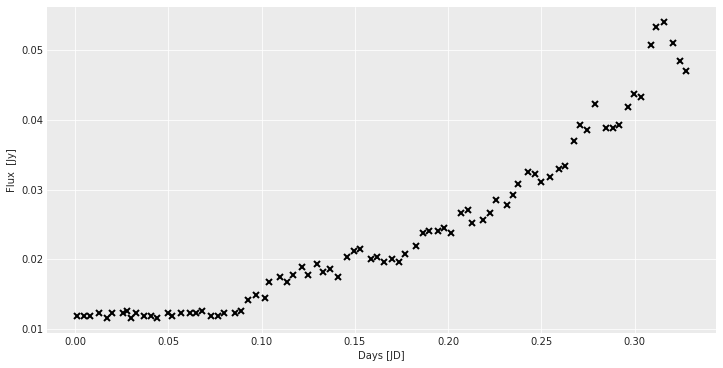

Background =  0.0192592593
Noise =  0.0070370371
ls =  0.0462015331191


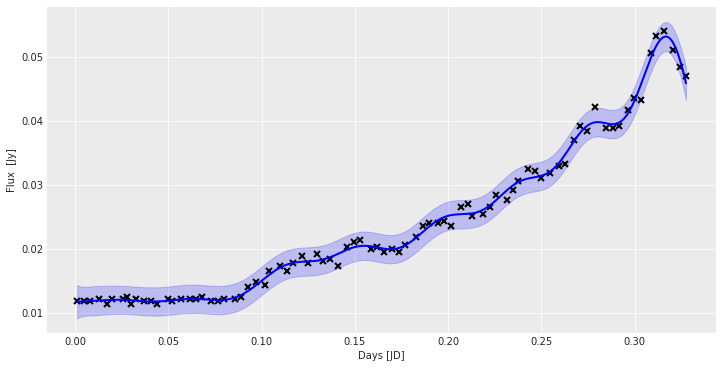

37 ../data/XRB/GROJ1655-40.txt


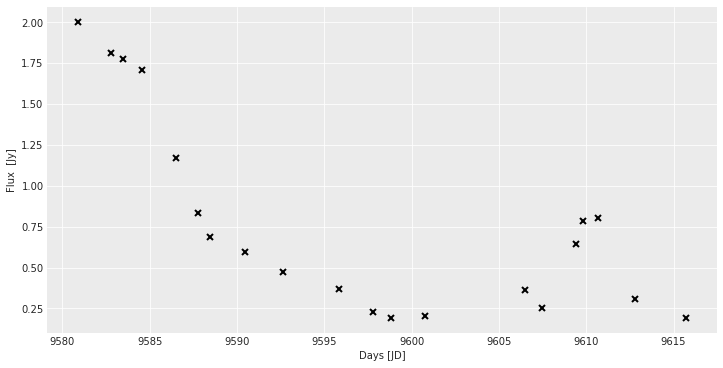

Background =  0.3706512911
Noise =  0.1781282299
ls =  4.98873484634


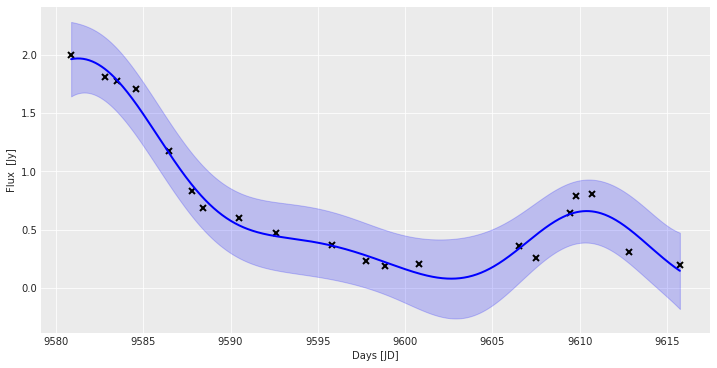

38 ../data/XRB/GX13+1.txt


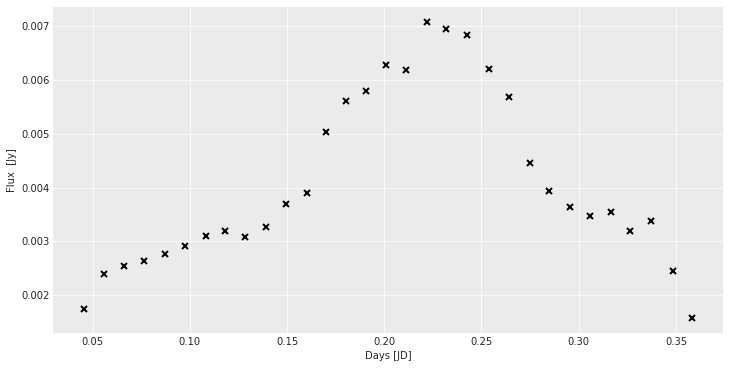

Background =  0.003198522
Noise =  0.0004356325
ls =  0.0753518463436


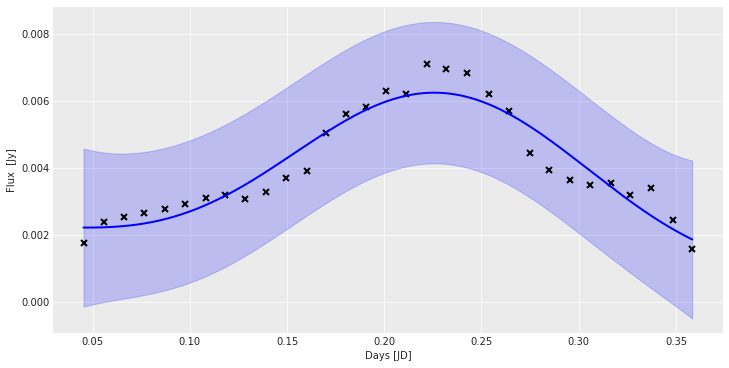

39 ../data/XRB/XTEJ1550-564.txt


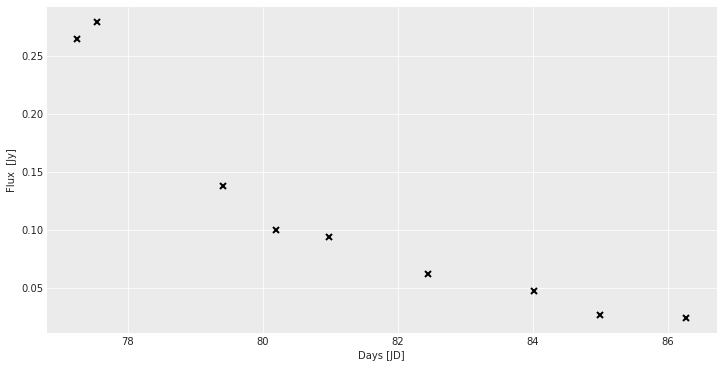

Background =  0.0617647058824
Noise =  0.0352941176471
ls =  1.58207002014


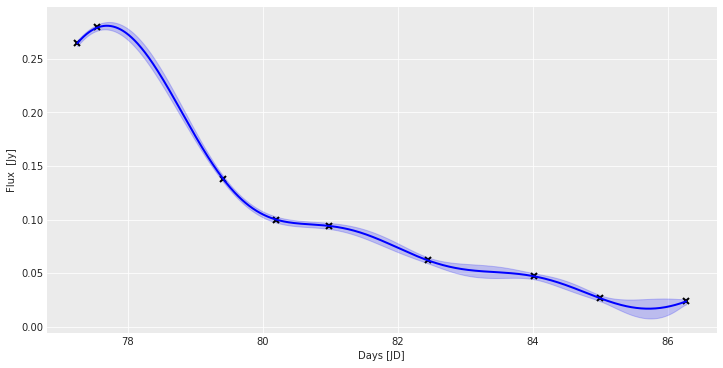

41 ../data/XRB/CirX-1


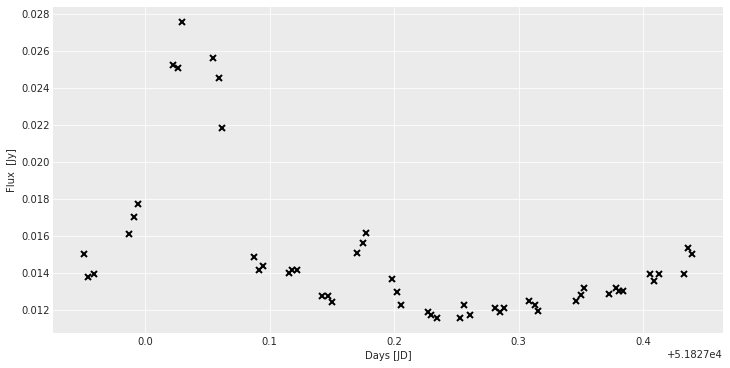

Background =  0.01302874875
Noise =  0.00091544245
ls =  0.0818200079468


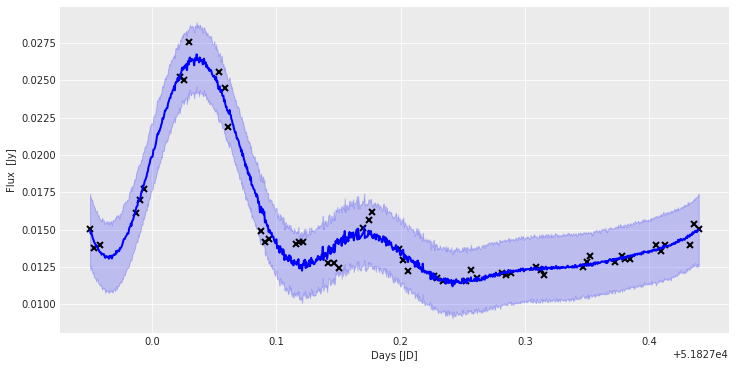

42 ../data/XRB/B1259-63.txt


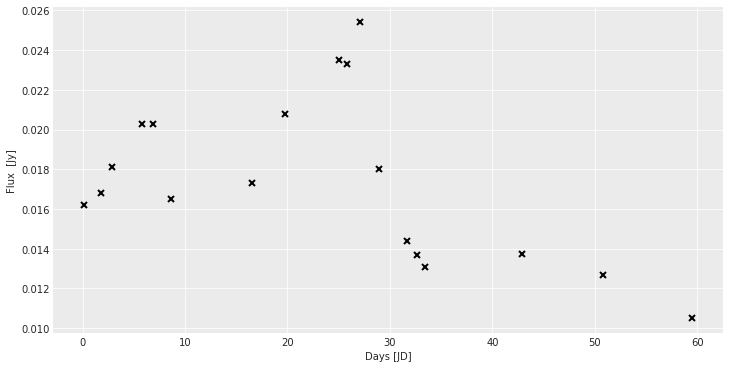

Background =  0.0170553074
Noise =  0.0032573568
ls =  5.27367247642


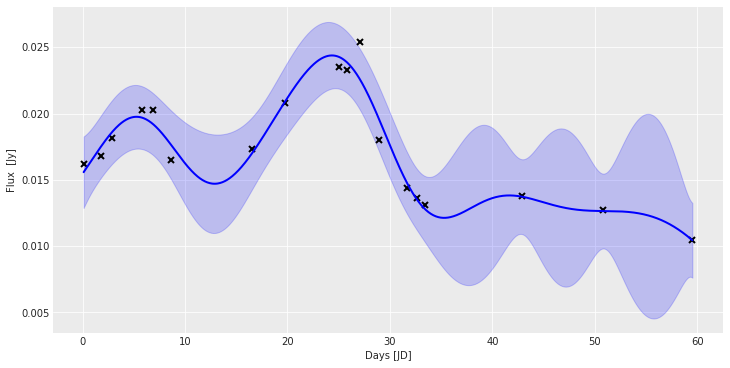

43 ../data/XRB/CygX-3.txt


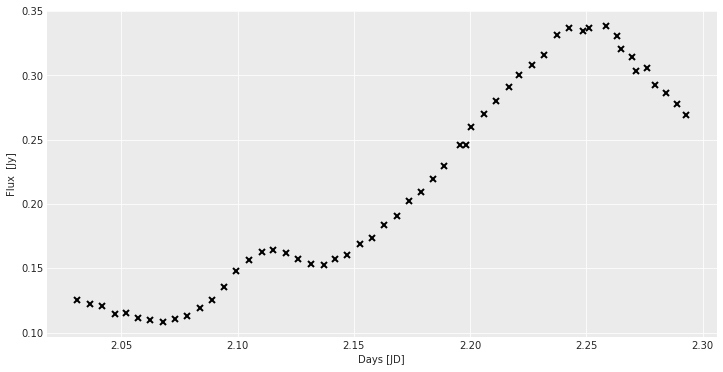

Background =  0.19660513335
Noise =  0.07512526275
ls =  0.0368306639325


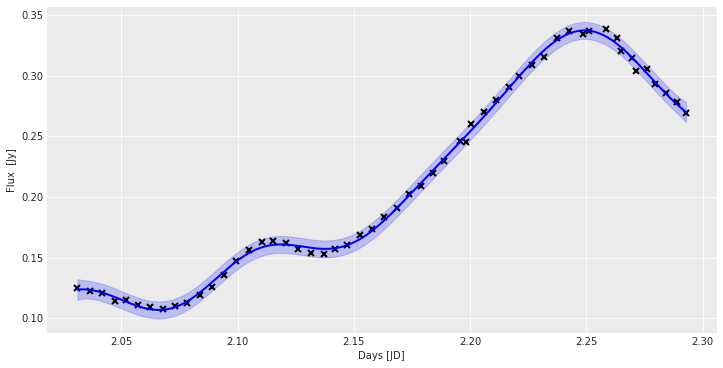

44 ../data/GRB/GRB970508.txt


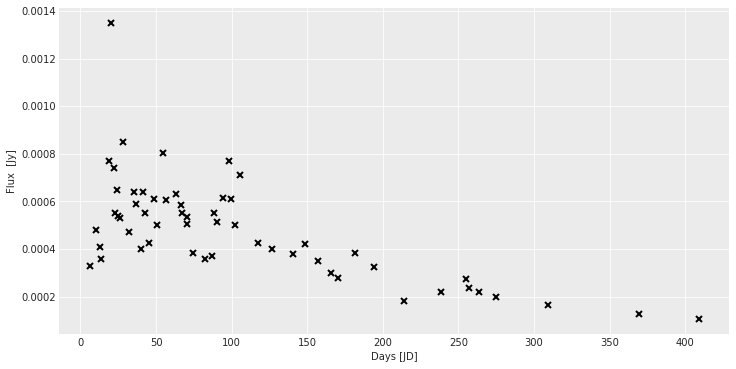

Background =  0.00049
Noise =  0.00012
ls =  4.03427855137


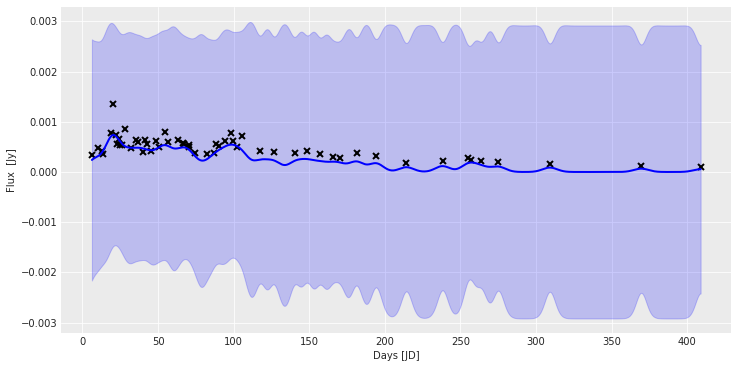

45 ../data/GRB/GRB030329.txt


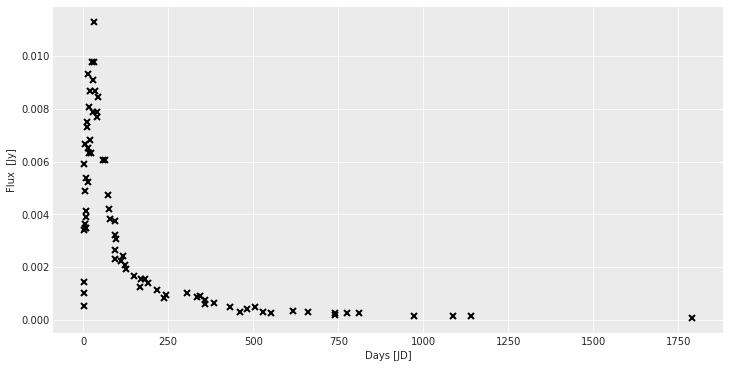

Background =  0.0003317671
Noise =  0.0001312814
ls =  204.090089741


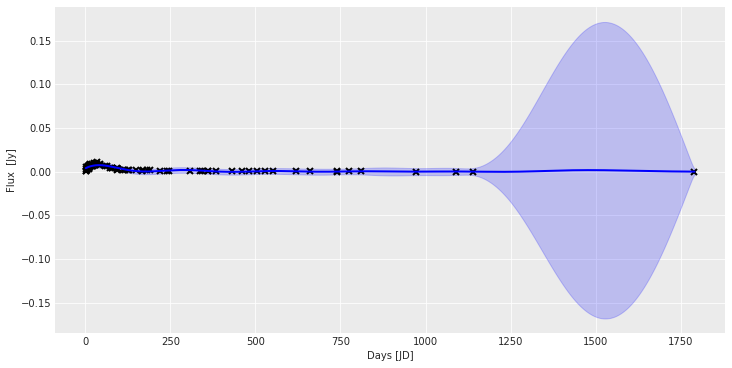

48 ../data/Nova/V1500Cyg.txt


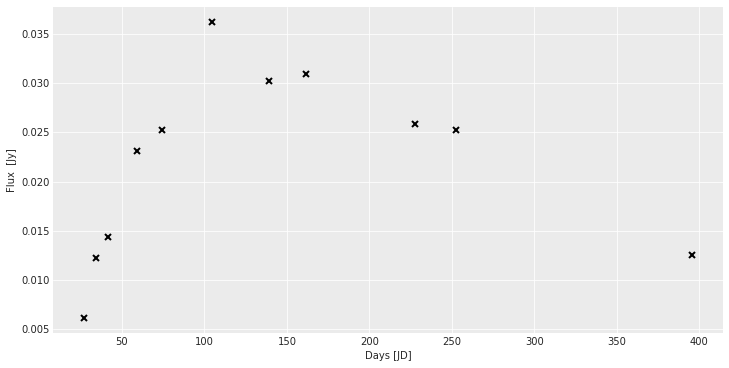

Background =  0.0252325291888
Noise =  0.00533932515157
ls =  27.516478046


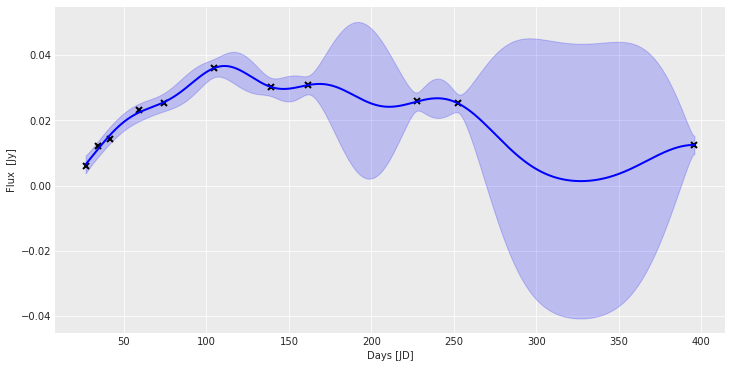

49 ../data/Nova/Sco2012.txt


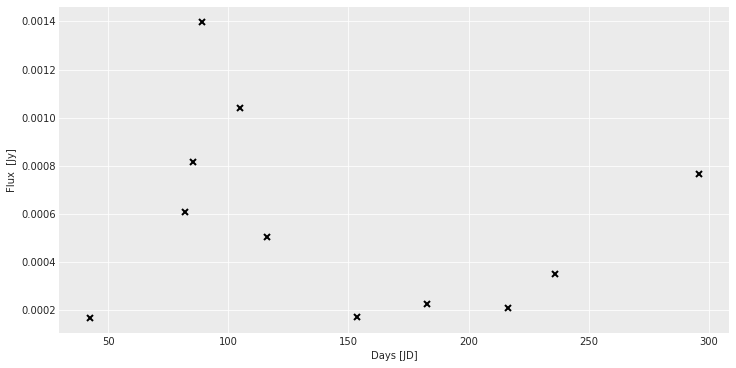

Background =  0.00042860195
Noise =  0.00023737215
ls =  14.4313756228


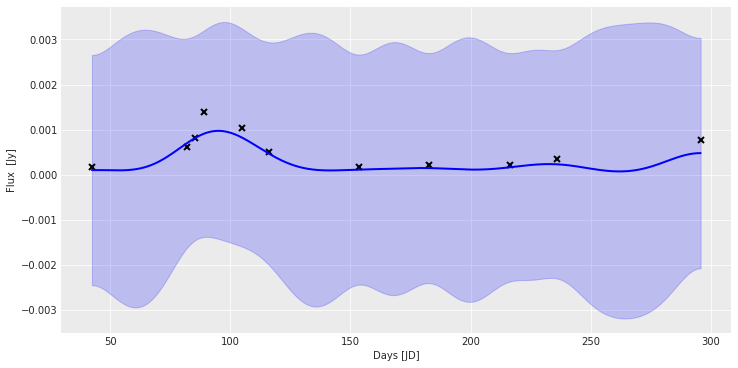

50 ../data/Nova/V1974Cyg.txt


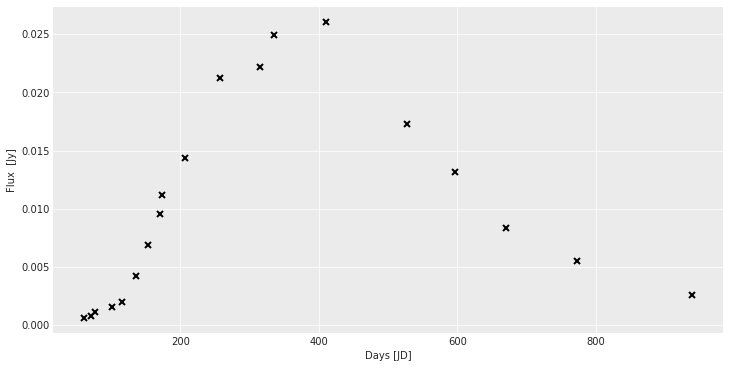

Background =  0.00833282150848
Noise =  0.00635115895424
ls =  165.540793492


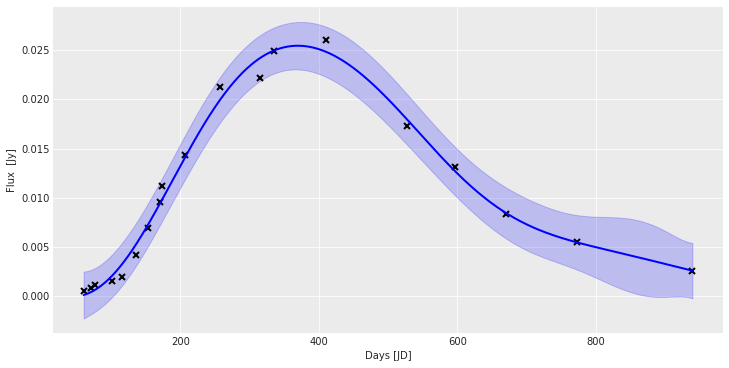

51 ../data/Nova/V1723Aql.txt


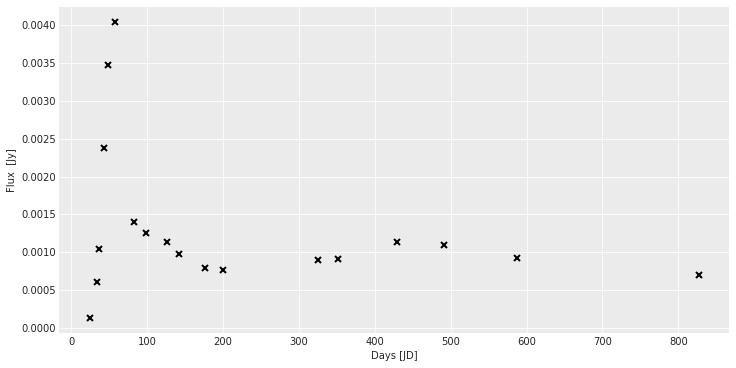

Background =  0.000954294043952
Noise =  0.000171729856481
ls =  44.651867239


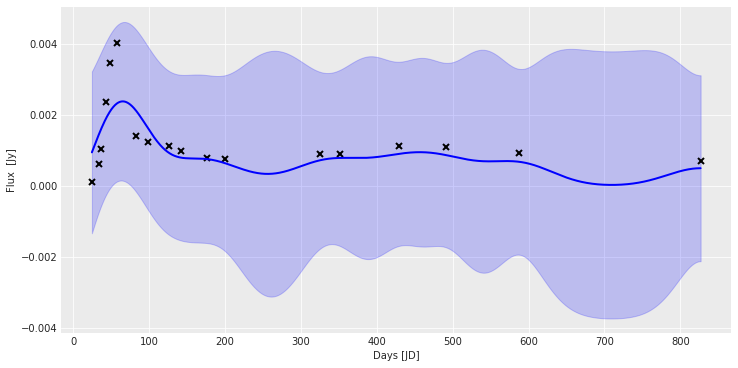

52 ../data/Nova/TPyx.txt


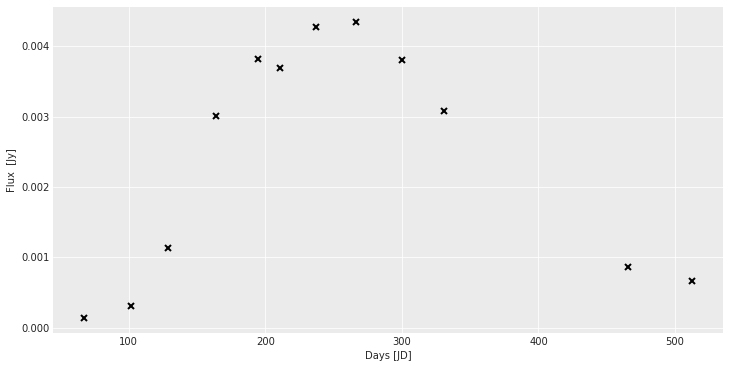

Background =  0.0030495
Noise =  0.001258
ls =  26.668704529


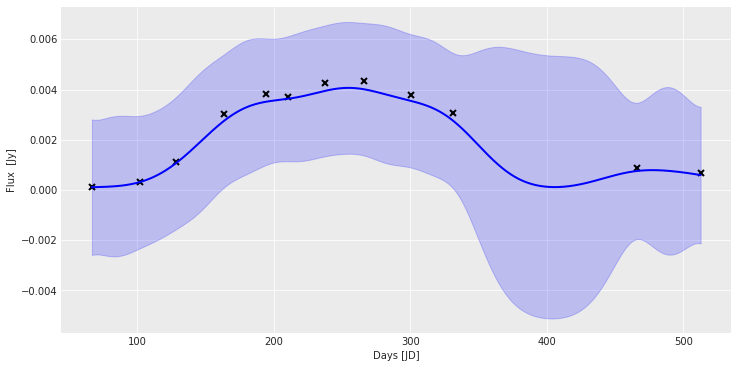

53 ../data/Nova/V407Cyg.txt


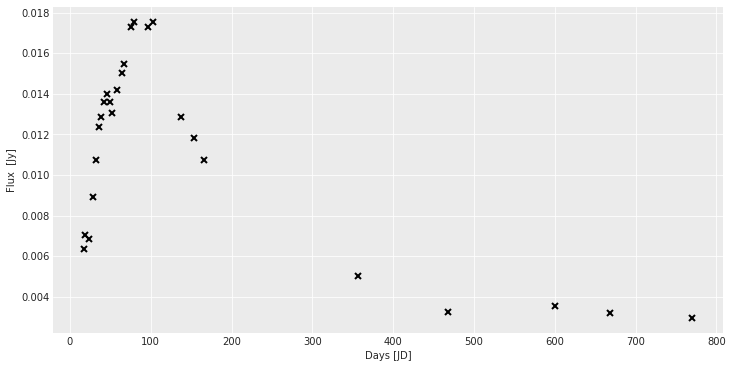

Background =  0.0126097379399
Noise =  0.00325792054652
ls =  30.1431925979


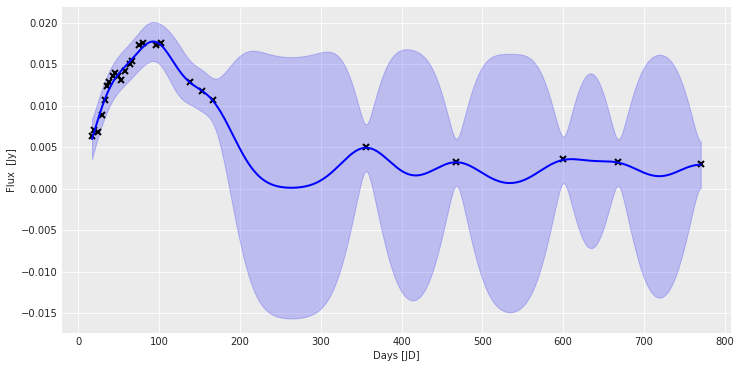

54 ../data/Nova/RSOph.txt


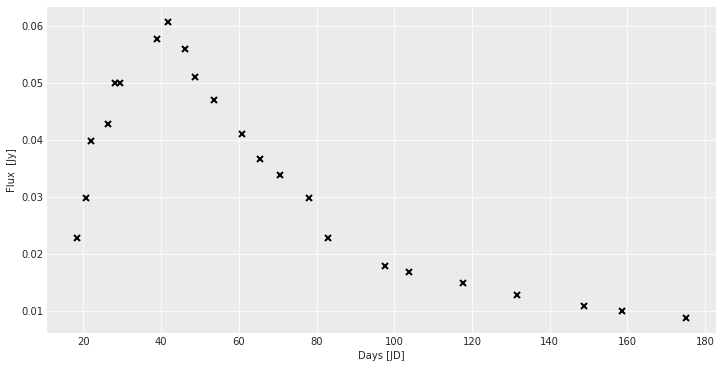

Background =  0.0338682339
Noise =  0.0161317661
ls =  11.5799480551


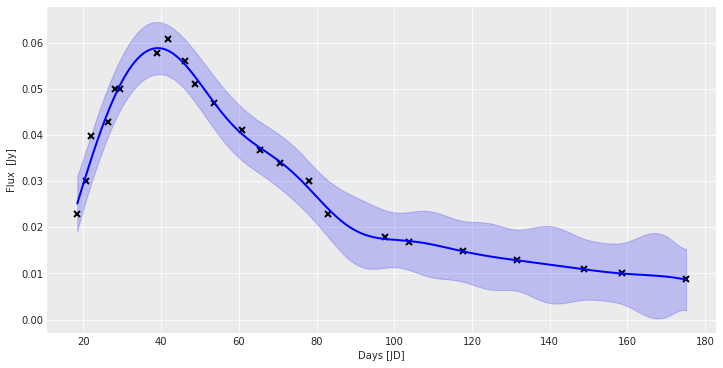

56 ../data/Magnetar/SGR1806-20.txt


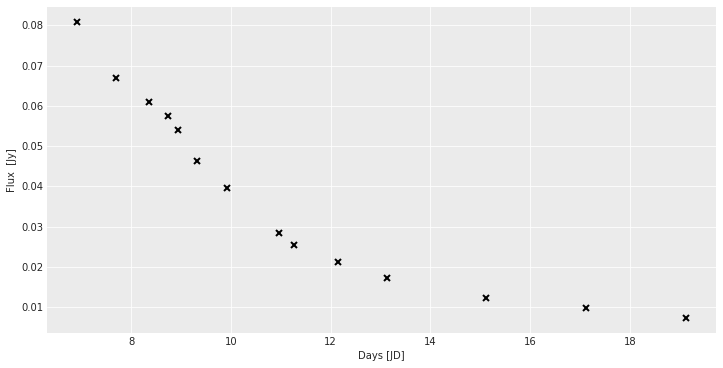

Background =  0.03405389545
Noise =  0.02078342115
ls =  0.853801307935


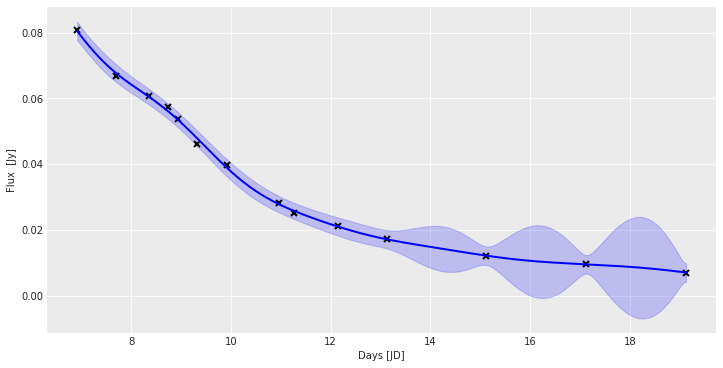

59 ../data/Flare-Star/ADLeo1.txt


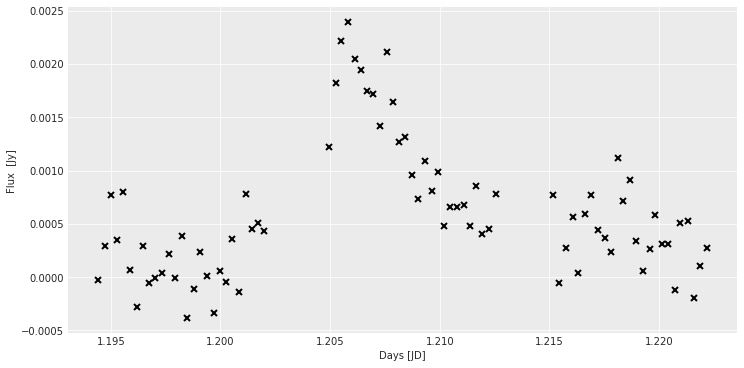

Background =  0.0003883333
Noise =  0.000327575724242
ls =  0.0036031834016


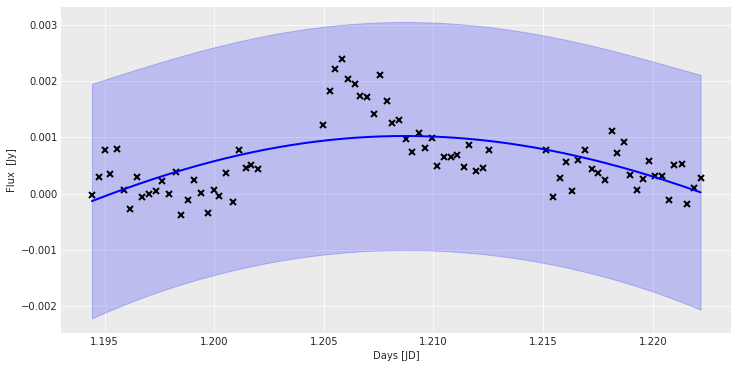

60 ../data/Flare-Star/UVCet


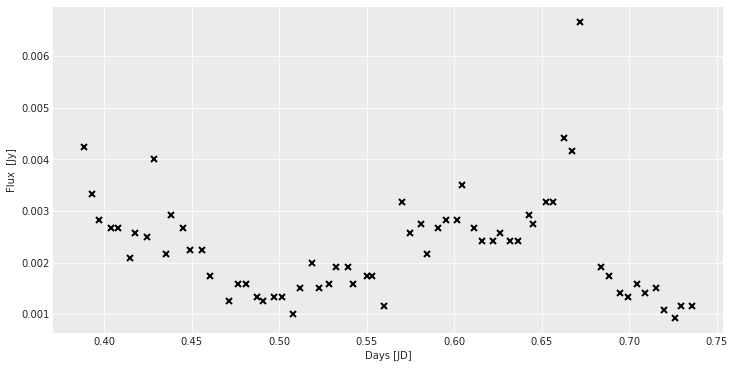

Background =  0.00204166665
Noise =  0.00062499995
ls =  0.0202574726679


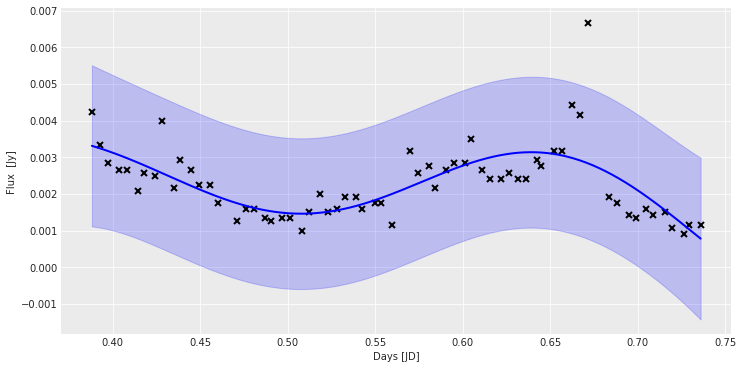

61 ../data/Flare-Star/YZCmi


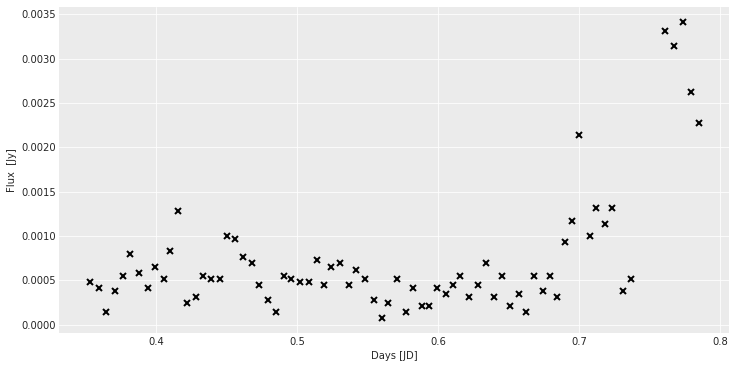

Background =  0.0004827586
Noise =  6.89655e-05
ls =  0.0147899141055


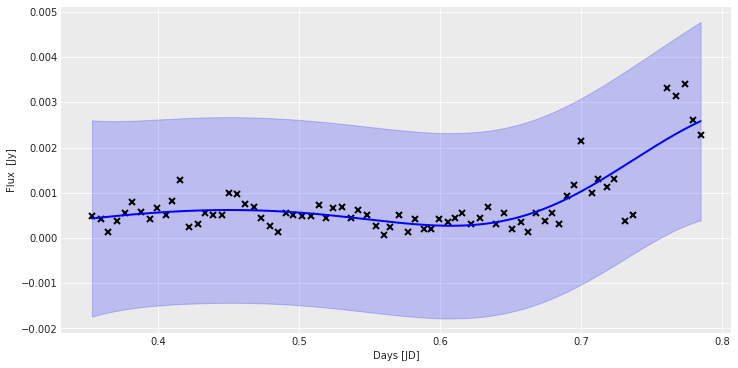

63 ../data/Magnetic-CV/AEAqr


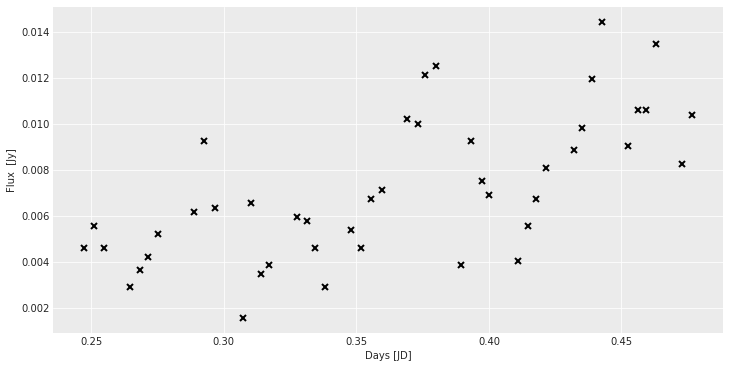

Background =  0.00644230765
Noise =  0.0023076923
ls =  0.023455098455


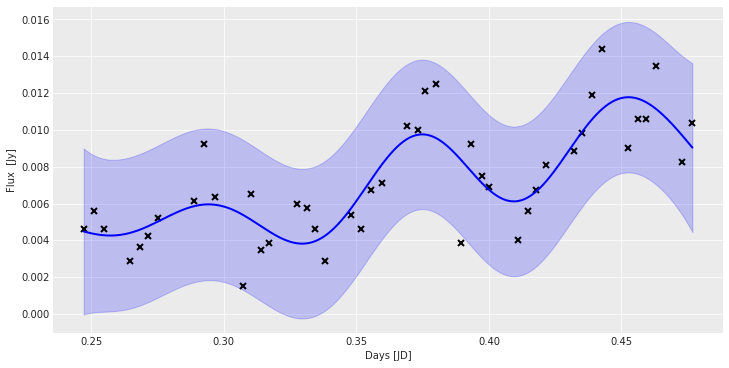

64 ../data/Algol/RZCAS.txt


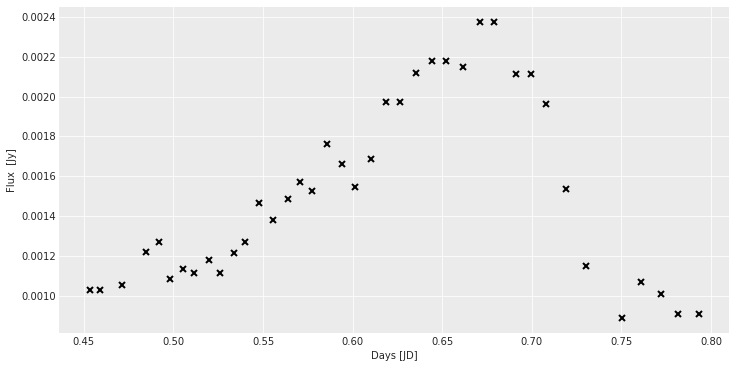

Background =  0.0014636566
Noise =  0.0003792347
ls =  0.0462091665262


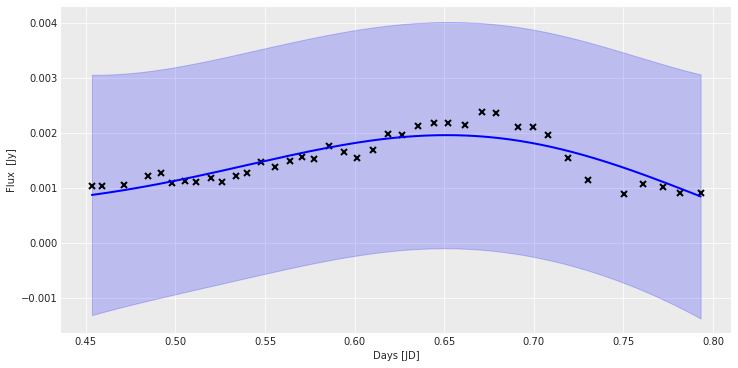

In [7]:
for i in range(len(allfiles)):
    file = allfiles[i]
    if file not in not_good:
        #if "GBI" in file:
        try: 
            print(i,file)
            test(file)
        except Exception as e:
            print(file, e)

In [6]:
not_good = ["../data/TDE/ASASSN-14li.txt",
               "../data/DwarfNova/SSCyg.txt",
               "../data/XRB/CygX-2p.txt",
               "../data/XRB/M31ULX.txt",
               "../data/GRB/GRB110709B.txt",
               "../data/GRB/GRB060418.txt",
               "../data/RSCVn/CFOct.txt",
               "../data/Flare-Star/AUMic.txt",
               "../data/Flare-Star/ADLeo",
               "../data/Magnetic-CV/V834Cen.txt",             
]
len(not_good)

10

In [ ]:
for i in not_working:
    try: 
        test(i)
    except Exception as e:
        print(i+ ' Failed', e)

In [ ]:
for i in not_working:
    try: 
        test(i)
    except Exception as e:
        print(i+ ' Failed', e)

In [ ]:
file = allfiles[13]
test(file)

In [ ]:
median_absolute_deviation?

In [ ]:
def gauss(x,x0,sigma):
    return np.exp(-((x-x0)**2)/(2*sigma**2))
x = np.linspace(0,1,100)
x0 = 0.7
pl.plot(x,gauss(x,x0,x0/10))

In [9]:
number_of_curves = 1
data_augment_root = "../data.augment/"

for j in range(len(allfiles)):
    datafile = allfiles[j]
    if datafile not in not_good:
        x,y,err = loadfile(datafile)
        xsample_range = np.arange(np.min(x),np.max(x),1)
        print('Sampling file: ', datafile)
        print('---------------------------------------------------------------')
        #try:
        if datafile.endswith('.txt'):
            datafile = datafile[:-4]
        filename = data_augment_root + datafile[len(root):]
        xnew,ynew = sample_curve(x,y,err,xsample_range,number_of_curves,filename)

#         for i in range(number_of_curves):
#             with open(filename +'_'+str(i),'w+') as f:
#                 writer = csv.writer(f, delimiter='\t')
#                 writer.writerows(zip(xnew[:,0],ynew[i][:,0],err))

        gc.collect()

Sampling file:  ../data/TDE/Swift1644.txt
---------------------------------------------------------------
Background =  0.0089
Noise =  0.00403
ls =  16.4980759706
Sampling file:  ../data/SN/SN1988z.txt
---------------------------------------------------------------
Background =  0.00167
Noise =  0.00018
ls =  173.261647259
Sampling file:  ../data/SN/SN1980K.txt
---------------------------------------------------------------
Background =  0.000355
Noise =  8e-05
ls =  144.809366949
Sampling file:  ../data/SN/SN2004dk.txt
---------------------------------------------------------------
Background =  0.00138348938351
Noise =  0.00063824399754
ls =  10.6897788926
Sampling file:  ../data/SN/SN1998bw.txt
---------------------------------------------------------------
Background =  0.02905
Noise =  0.00395
ls =  5.86032042199


Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x7ff12e91b2b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 705, in __del__
    tf_session.TF_DeleteDeprecatedSession(self._session, status)
KeyboardInterrupt: 


Sampling file:  ../data/SN/SN1993J.txt
---------------------------------------------------------------
Background =  0.03885
Noise =  0.033177
ls =  114.267755011
Sampling file:  ../data/SN/SN2008iz
---------------------------------------------------------------
Background =  3.5117647059
Noise =  0.0067226891
ls =  216.658026832
Sampling file:  ../data/SN/SN2008ax.txt
---------------------------------------------------------------
Background =  0.00227579385
Noise =  0.0006159243
ls =  8.91871866159
Sampling file:  ../data/SN/SN2003bg.txt
---------------------------------------------------------------
Background =  0.03114
Noise =  0.00877
ls =  42.0414291143


KeyboardInterrupt: 

In [11]:
ynew

array([[[ 0.00183177],
        [ 0.0015414 ],
        [ 0.00197547],
        [ 0.00298774],
        [ 0.00212807],
        [ 0.00110751],
        [ 0.00571704],
        [ 0.00176378],
        [ 0.00495654],
        [ 0.00554409],
        [ 0.00404631],
        [ 0.00486469],
        [ 0.00512325],
        [ 0.00546556],
        [ 0.00219704],
        [ 0.00332688],
        [ 0.00467868],
        [ 0.00305818],
        [ 0.00132669],
        [ 0.00156379],
        [ 0.00266075],
        [ 0.00082563],
        [ 0.00226991],
        [ 0.0025566 ],
        [ 0.00066701],
        [ 0.00174114],
        [ 0.00130033],
        [ 0.0037163 ],
        [ 0.00380515],
        [ 0.00175829],
        [ 0.00448336],
        [ 0.00395372],
        [ 0.00369064],
        [ 0.00326197],
        [ 0.00241926],
        [ 0.00289763],
        [ 0.00307038],
        [ 0.00147654],
        [ 0.00070446],
        [ 0.00080025],
        [ 0.00096367],
        [ 0.00085056],
        [ 0.00272345],
        [ 0